In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,precision_score, recall_score, f1_score, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

Dados atualizados em 22/02/2024

In [4]:
tbl_dam = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_dam_debito_22_02.csv'
tbl_historico_contribuinte = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\tbl_historico_contribuinte_db_22_02.csv'

In [6]:
df_dam = pd.read_csv(tbl_dam, encoding='utf-8')
df_historico_contribuinte = pd.read_csv(tbl_historico_contribuinte, encoding='utf-8')

In [5]:
grandes_numeros = df_dam.groupby(['ano_fato_gerador']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum'
}).reset_index()

grandes_numeros['vlr_lancado'] = (grandes_numeros['vlr_aberto'] + grandes_numeros['vlr_pago']).apply(formatar_moeda)
grandes_numeros['vlr_aberto'] = grandes_numeros['vlr_aberto'].apply(formatar_moeda)
grandes_numeros['vlr_pago'] = grandes_numeros['vlr_pago'].apply(formatar_moeda)
grandes_numeros

NameError: name 'df_dam' is not defined

## MANIPULAÇÃO DE DADOS DA DÍVIDA

In [244]:
df_dam.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,39.0,2944.1,0.0,0.0,2944.1
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,39.0,2627.7,0.0,0.0,2627.7
2,000032f6d93a0abd,5c392b470f1f27a1295a294a15cb156f,71fc88ab6bbb201c344d77602867ec09,2024.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2024-01-01,0.0,39.0,0.0,1804.4,0.0,1804.4
3,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,39.0,3335.1,0.0,0.0,3335.1
4,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,39.0,3630.4,0.0,0.0,3630.4


In [245]:
contagem_imovel = df_dam.groupby('id_contribuinte')['id_imovel'].nunique()
registros_duplicados = df_dam[df_dam['id_contribuinte'].isin(contagem_imovel[contagem_imovel > 1].index)]
registros_duplicados.query('id_contribuinte == "4c375f5fe6f11e99cd124eb8021f7dca"')

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_acessorio_dam,vlr_total_dam
22,0000c599ab737fa1,35a5f340f67738f419002eec9f619408,4c375f5fe6f11e99cd124eb8021f7dca,2021.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2021-02-09,1.0,52.0,1112.60,0.00,0.00,1112.60
23,0000c599ab737fa1,491bd50714736f724c1f696350fff79e,4c375f5fe6f11e99cd124eb8021f7dca,2019.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2019-02-07,1.0,52.0,1055.40,0.00,0.00,1055.40
24,0000c599ab737fa1,52a09679bbf7a68690ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2023-12-19,0.0,52.0,0.00,1697.79,401.79,1697.79
25,0000c599ab737fa1,8360ed1065c0c9b611babe4a46e18b6d,4c375f5fe6f11e99cd124eb8021f7dca,2018.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2018-02-07,1.0,52.0,1014.70,0.00,0.00,1014.70
26,0000c599ab737fa1,8b7cc9eb1c4ce7c5e08920064611a7cf,4c375f5fe6f11e99cd124eb8021f7dca,2017.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2017-02-03,1.0,52.0,993.01,0.00,0.00,993.01
27,0000c599ab737fa1,bf7dabc23fbda539295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2024-01-01,0.0,52.0,0.00,1350.50,0.00,1350.50
28,0000c599ab737fa1,db7cb92fb806efc0875350beaddc7871,4c375f5fe6f11e99cd124eb8021f7dca,2022.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2022-01-31,1.0,52.0,1224.40,0.00,0.00,1224.40
29,0000c599ab737fa1,fbee00a70512c0e40ba9f03948490762,4c375f5fe6f11e99cd124eb8021f7dca,2020.0,1,125.00,1,P,APARTAMENTO,CONSTRUÍDA,BOA VIAGEM,2008-12-11 23:02:50,2020-02-07,1.0,52.0,1076.40,0.00,0.00,1076.40
402292,2b4e52aa40ed629d,56e1417b75d5110f295a294a15cb156f,4c375f5fe6f11e99cd124eb8021f7dca,2024.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2024-01-01,0.0,42.0,0.00,2865.40,0.00,2865.40
402293,2b4e52aa40ed629d,bb49f934732c9ea890ecf5aaf6be6eb7,4c375f5fe6f11e99cd124eb8021f7dca,2023.0,1,125.26,1,P,CASA,CONSTRUÍDA,ZUMBI,2008-12-11 19:06:14,2023-12-19,0.0,42.0,0.00,3591.50,850.30,3591.50


EURÍSTICA DE MANIPULAÇÃO DE DADOS ADOTADA
dam
ano_fato_gerador
id_imovel
idade_imovel 
vlr_aberto
vlr_pago
area_construida 
tipo_propriedade
bairro
natureza_imovel - tranforma p em 1 e t em 0
NOVA COLUNA chamada vlr_lançado = vlr_aberto + vlr_pago
NOVA COLUNA chamada aberto = se vlr_lançado = vlr_pago atribuir 1, se não atribuir 0

In [246]:
# dummizando a variavel de natureza de imóvel
mapeamento_natureza = {'P': 1, 'T': 0}
df_dam['natureza_imovel'] = df_dam['natureza_imovel'].map(mapeamento_natureza)

In [247]:
colunas_selecionadas = ['dam',  'id_imovel', 'id_contribuinte', 'ano_fato_gerador', 'natureza_imovel', 'idade_imovel', 'area_construida',
                      'tipo_propriedade', 'bairro', 'vlr_aberto', 'vlr_pago']

feature_dam = df_dam[colunas_selecionadas].copy()

feature_dam['vlr_lancado'] = feature_dam['vlr_aberto'] + feature_dam['vlr_pago']
feature_dam['aberto'] = (feature_dam['vlr_lancado'] != feature_dam['vlr_pago']).astype(int)
feature_dam

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.00,1804.40,1
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385006,c0ff37bd120cc0d619002eec9f619408,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,568.39,568.39,0
2385007,c8d60514c5f4b18ee08920064611a7cf,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,503.20,503.20,0
2385008,d97d28d5be81653f295a294a15cb156f,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2024.0,1,42.0,89.15,APARTAMENTO,VARZEA,692.0,0.00,692.00,1
2385009,e46ab0c52787357611babe4a46e18b6d,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,1,42.0,89.15,APARTAMENTO,VARZEA,0.0,515.10,515.10,0


In [248]:
df_dam_nulos = feature_dam[feature_dam['bairro'].isnull()]
df_dam_nulos.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
181022,28e87ba0e6079ed80ba9f03948490762,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,1,8.0,NaN,NaN,NaN,0.00,1260.20,1260.20,0
181023,4b65dd3735737b29e08920064611a7cf,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,1,8.0,NaN,NaN,NaN,1713.41,0.00,1713.41,1
181024,4f963eccb4677558295a294a15cb156f,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2024.0,1,8.0,NaN,NaN,NaN,1611.90,0.00,1611.90,1
181025,7fd0786f77af52324c1f696350fff79e,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2019.0,1,8.0,NaN,NaN,NaN,0.00,1240.02,1240.02,0
181026,9803a33efc9734c9875350beaddc7871,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,1,8.0,NaN,NaN,NaN,0.00,1447.40,1447.40,0


### TRATAMENTO DOS VALORES NULOS

In [249]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

# retirar os id_contribuinte nulos ou sem documento
# area_construida preencher com 0
# idade_imovel preencher com 0         
# tipo_propriedade preencher com 'TERRENO'  
# bairro preencher com 'DESCONHECIDO'

dam                      0
id_imovel                0
id_contribuinte     102224
ano_fato_gerador         0
natureza_imovel          0
idade_imovel         12144
area_construida      56961
tipo_propriedade     56961
bairro                  62
vlr_aberto               0
vlr_pago                 0
vlr_lancado              0
aberto                   0
dtype: int64

In [250]:
feature_dam = feature_dam.dropna(subset=['id_contribuinte']).copy()
feature_dam['area_construida'].fillna(0, inplace=True)
feature_dam['idade_imovel'].fillna(0, inplace=True)
feature_dam['tipo_propriedade'].fillna('TERRENO', inplace=True)
feature_dam['bairro'].fillna('DESCONHECIDO', inplace=True)


In [251]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

In [252]:
feature_dam.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.1,2944.1,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.7,2627.7,0
2,5c392b470f1f27a1295a294a15cb156f,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2024.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,1804.4,0.0,1804.4,1
3,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.1,3335.1,0
4,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,1,39.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.4,3630.4,0


## MANIPULAÇÃO DE DADOS DO CONTRIBUINTE

In [253]:
df_historico_contribuinte.head()

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
0,2013,00001a3e5b2177499daa7b7dbb545c1c,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2013,0000398c485f8b42344d77602867ec09,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2013,00003a695da4777aec557718ffae83ea,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,2013,000046c85d18a6f7968646cfc1e328f2,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,PF,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [254]:
df_historico_contribuinte.query('id_contribuinte == "878ed023fa473bede000edc2a2086273"')

,ano,id_contribuinte,tipo_pessoa,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
133429,2013,878ed023fa473bede000edc2a2086273,PJ,1,1,1,45,66,0,1,1,10490.99,8885.30,19376.29
385578,2014,878ed023fa473bede000edc2a2086273,PJ,1,1,1,71,104,0,1,1,25166.48,14880.31,40046.79
637727,2015,878ed023fa473bede000edc2a2086273,PJ,1,0,1,44,714,0,1,1,1263591.14,20235.09,1283826.23
889876,2016,878ed023fa473bede000edc2a2086273,PJ,1,1,1,418,1086,0,1,2,1202250.30,176523.00,1378773.30
1142025,2017,878ed023fa473bede000edc2a2086273,PJ,0,1,1,604,622,0,1,1,17564.20,292110.69,309674.89
1394174,2018,878ed023fa473bede000edc2a2086273,PJ,0,1,1,534,557,0,1,1,19099.46,270736.76,289836.22
1646323,2019,878ed023fa473bede000edc2a2086273,PJ,0,1,1,524,538,0,1,1,10322.57,293571.32,303893.89
1898472,2020,878ed023fa473bede000edc2a2086273,PJ,0,1,1,454,474,0,1,1,15849.68,270856.96,286706.64
2150621,2021,878ed023fa473bede000edc2a2086273,PJ,0,1,1,460,472,0,1,1,10440.09,280505.01,290945.10
2402770,2022,878ed023fa473bede000edc2a2086273,PJ,1,1,1,456,1557,1,1,1,1835467.49,309157.66,2144625.15


EURÍSTICA ADOTADA PARA MANIPULAÇÃO DE DADOS

id_contribuinte
pgt_cota_unica
hist_pagamento
hist_valor_lançado
num_imoveis
reco_divida 
existe esta coluna reco_debito, eu calculei para esta coluna o valor contido em reco_debito + o valor contido em reco_divida sendo o total preenchido na coluna reco_debito
NOVA COLUNA reco_credito = a logica dessa coluna será a seguinte: será contar quantos id_contribuinte tem quando hist_valor_total for diferente de 0 em relação aos anos anteriores. exemplo: eu tenho na minha base o registo xxxx e eu tenho na base os anos entre 2013 e 2023 certo? quando for o registro de 2017 desse contribuinte xxxx eu vou realizar a logica olhando quantas vezes esse id_contribuinte apareceu até este ano em que o hist_valor_total foi diferente de 0 considerando tambem o ano atual, neste exemplo 2017 no caso, e assim cada ano eu terei a quantidade atualizada.

# Construção das variáveis de histórico e acumulativas ano a ano

In [255]:
feature_contribuinte = df_historico_contribuinte[['ano', 'id_contribuinte','reco_debito', 'pgt_cota_unica', 'hist_valor_pago', 'hist_valor_total', 'num_imoveis', 'reco_divida_ativa']].copy()
feature_contribuinte['hist_cota_unica'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

# Construindo variavel historico de pagamento e valor lançado do contribuinte
feature_contribuinte['hist_pagamento'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_pago'].cumsum()
feature_contribuinte['hist_lancado'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].cumsum()

# reco_debito
feature_contribuinte['reco_debito'] = feature_contribuinte['reco_debito'] + feature_contribuinte['reco_divida_ativa']

# reco_credito
feature_contribuinte['reco_credito'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].apply(lambda x: (x.shift(1) != 0).cumsum())
feature_contribuinte['reco_credito'] = np.where(feature_contribuinte['hist_valor_total'] == 0, 0, feature_contribuinte['reco_credito'])

feature_contribuinte


,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0.00,0.00,0,0,0,0.00,0.00,0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0.00,0.00,0,0,0,0.00,0.00,0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0.00,0.00,0,0,0,0.00,0.00,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0.00,0.00,0,0,0,0.00,0.00,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0.00,0.00,0,0,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2773634,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,645.20,645.20,1,0,0,3202.69,3789.56,7
2773635,2023,ffff3836dbf935321bc34267b5521a39,0,0,5913.49,5913.49,1,0,0,37074.07,37074.07,8
2773636,2023,ffff63826b501d84d8b209292c0ce31d,0,0,2085.70,2085.70,1,0,0,13677.51,13677.51,8
2773637,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2532.70,2532.70,2,0,1,14683.46,14683.46,7


In [256]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito
44661,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
296810,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0
548959,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1
801108,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,1482.67,0
1053257,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,0,0,0,0.00,1482.67,0
1305406,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2
1557555,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3
1809704,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4
2061853,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5
2314002,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6


## Variável percentual do Pagamento em cota única ano a ano 

In [257]:
# Criando a variável de percentual pago em cota única em cada ano por contribuinte
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_pgt_cota'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan

feature_contribuinte['percentual_pago_cota'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_pgt_cota'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_24084\1393049071.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_pgt_cota'] / max_reco_credito[id_contribuinte]) if id_contribuinte in max_reco_credito.index else np.nan


## Variável percentual de Recorrência em débito ano a ano 

In [258]:
# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_credito = feature_contribuinte.groupby('id_contribuinte')['reco_credito'].max()

feature_contribuinte['acumulado_reco_debito'] = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].cumsum()

def calculate_percentual_reco_debito(row):
    id_contribuinte = row['id_contribuinte']
    max_credito = max_reco_credito.get(id_contribuinte, 1)  # Evita divisão por zero
    acumulado_debito = row['acumulado_reco_debito']
    
    if max_credito == 0 or acumulado_debito == 0:
        return 0
    
    percentual = (acumulado_debito / max_credito) * 100
    return min(percentual, 100) / 100  # Trunco o valor

feature_contribuinte['percentual_reco_debito'] = feature_contribuinte.apply(calculate_percentual_reco_debito, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_debito'])

# parei aqui sadvljndfjl fd blajfdb 

In [259]:
feature_contribuinte.query('id_contribuinte == "00055311bbe1c1dd980abaecbf686355"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito
16,2013,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,0.5
252165,2014,00055311bbe1c1dd980abaecbf686355,1,0,0.0,0.00,0,1,0,0.0,0.00,0,0.0,1.0
504314,2015,00055311bbe1c1dd980abaecbf686355,1,0,0.0,1971.09,4,0,0,0.0,1971.09,1,0.0,1.0
756463,2016,00055311bbe1c1dd980abaecbf686355,2,0,0.0,1866.50,4,1,0,0.0,3837.59,2,0.0,1.0
1008612,2017,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1260761,2018,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1512910,2019,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
1765059,2020,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2017208,2021,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0
2269357,2022,00055311bbe1c1dd980abaecbf686355,0,0,0.0,0.00,0,0,0,0.0,3837.59,0,0.0,1.0


## Variável percentual de Recorrência em dívida ativa ano a ano 

In [21]:
# Criando a variável de percentual de recorrência em dívida ativa para cada Ano

# Meu denominador que seria quantos créditos o contribuinte tem 
max_reco_debito = feature_contribuinte.groupby('id_contribuinte')['reco_debito'].sum()

feature_contribuinte['acumulado_reco_divida_ativa'] = feature_contribuinte.groupby('id_contribuinte')['reco_divida_ativa'].cumsum()

def calculate_percentual_pago_cota(row):
    id_contribuinte = row['id_contribuinte']
    return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan

feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte.apply(calculate_percentual_pago_cota, axis=1)
feature_contribuinte = feature_contribuinte.drop(columns=['acumulado_reco_divida_ativa'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_24084\1834496839.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (row['acumulado_reco_divida_ativa'] / max_reco_debito[id_contribuinte]) if id_contribuinte in max_reco_debito.index else np.nan


In [22]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
44513,2013,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0,0.000000,0.142857,0.333333
295783,2014,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,0.00,0,0.000000,0.285714,0.666667
547053,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,1482.67,1,0,0,0.00,1482.67,1,0.000000,0.285714,0.666667
798323,2016,2d6ae6e5dd1e57efae08d57f53945088,1,0,0.00,0.00,0,1,0,0.00,1482.67,0,0.000000,0.428571,1.000000
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0.00,0.00,0,0,0,0.00,1482.67,0,0.000000,0.428571,1.000000
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1818.18,1818.18,1,0,1,1818.18,3300.85,2,0.142857,0.428571,1.000000
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1814.94,1814.94,1,0,2,3633.12,5115.79,3,0.285714,0.428571,1.000000
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1811.40,1811.40,1,0,3,5444.52,6927.19,4,0.428571,0.428571,1.000000
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1807.74,1807.74,1,0,4,7252.26,8734.93,5,0.571429,0.428571,1.000000
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1803.81,1803.81,1,0,5,9056.07,10538.74,6,0.714286,0.428571,1.000000


In [23]:
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_pago'])
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_total'])

In [24]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                                   0
id_contribuinte                       0
reco_debito                           0
pgt_cota_unica                        0
num_imoveis                           0
reco_divida_ativa                     0
hist_cota_unica                       0
hist_pagamento                        0
hist_lancado                          0
reco_credito                          0
percentual_pago_cota             332552
percentual_reco_debito                0
percentual_reco_divida_ativa    1439867
dtype: int64

In [25]:
feature_contribuinte.query('percentual_reco_divida_ativa.isnull()')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
7,2013,00022915d03c589c0b59a1d5bcae3806,0,0,0,0,0,0.00,0.00,0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763962,2023,fffea8c8c9cd46b4344d77602867ec09,0,0,0,0,0,0.00,0.00,0,NaN,0.0,NaN
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.0,NaN
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.0,NaN
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.0,NaN


In [26]:
# Os registros nulos são onde o contribuinte aparece na base mas, não tem nenhum lançamento e nenhum valor para o mesmo
feature_contribuinte['percentual_pago_cota'] = feature_contribuinte['percentual_pago_cota'].fillna(0)
feature_contribuinte['percentual_reco_divida_ativa'] = feature_contribuinte['percentual_reco_divida_ativa'].fillna(0)

# Equalizando o recorte de bases

### Após contruir as variáveis e comportamento do contribuinte desde 2013, realizo o recorte para a partir de 2017 para união com o recorte da base de DAM's

In [27]:
feature_contribuinte = feature_contribuinte.query('ano >= 2017')
feature_contribuinte

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1005080,2017,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0.00,0.00,0,0.000000,0.000000,0.0
1005081,2017,0000398c485f8b42344d77602867ec09,0,0,1,0,0,721.31,721.31,1,0.000000,0.000000,0.0
1005082,2017,00003a695da4777aec557718ffae83ea,0,0,1,0,0,2668.51,2668.51,2,0.000000,0.000000,0.0
1005083,2017,000046c85d18a6f7968646cfc1e328f2,0,0,1,0,0,5542.50,5542.50,2,0.000000,0.000000,0.0
1005084,2017,0000b23be5378f1b8e79cf1867e8cc19,0,0,4,0,0,3624.20,3624.20,2,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,0,1,0,0,3202.69,3789.56,7,0.000000,0.142857,1.0
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,0,1,0,0,37074.07,37074.07,8,0.000000,0.000000,0.0
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,0,1,0,0,13677.51,13677.51,8,0.000000,0.000000,0.0
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,0,1,2,0,1,14683.46,14683.46,7,0.142857,0.000000,0.0


In [28]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                             0
id_contribuinte                 0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [29]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
natureza_imovel     0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

---

# UNIFICANDO BASE DE DAMS's COM A BASE DE INFORMAÇÃO DO CONTRIBUINTE

### EURÍSTICA ADOTADA

* Cada Dam reflete um ano em específico
* Os dados do contribuinte estão na mesma granularidade que a DAM

In [30]:
feature_dam.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
1461637,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,1799.62,0
1461638,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,1807.74,0
1461639,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,1803.81,0
1461640,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,1814.94,0
1461641,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,1811.40,0
1461642,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,1818.18,0


In [31]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,reco_debito,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0,0,0,0.00,1482.67,0,0.000000,0.428571,1.0
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,1,1818.18,3300.85,2,0.142857,0.428571,1.0
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,2,3633.12,5115.79,3,0.285714,0.428571,1.0
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,3,5444.52,6927.19,4,0.428571,0.428571,1.0
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,4,7252.26,8734.93,5,0.571429,0.428571,1.0
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,5,9056.07,10538.74,6,0.714286,0.428571,1.0
2557213,2023,2d6ae6e5dd1e57efae08d57f53945088,0,1,1,0,6,10855.69,12338.36,7,0.857143,0.428571,1.0


In [32]:
feature_store_credito = pd.merge(feature_dam, feature_contribuinte, 
                  left_on=['id_contribuinte', 'ano_fato_gerador'], 
                  right_on=['id_contribuinte', 'ano'], 
                  how='left')
feature_store_credito
feature_store_credito = feature_store_credito.sort_values(by=['id_contribuinte', 'ano'])
feature_store_credito

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,1,55.0,110.15,CASA,AREIAS,0.00,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,1,55.0,110.15,CASA,AREIAS,1306.50,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,1,55.0,110.15,CASA,AREIAS,1158.44,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2018.0,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,...,0.0,1.0,0.0,0.0,4155.11,4155.11,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265931,ef11c710269f05504c1f696350fff79e,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2019.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,4678.52,4678.52,5.0,0.0,0.0,0.0
265929,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5310.62,5310.62,6.0,0.0,0.0,0.0
265927,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,5944.02,5944.02,7.0,0.0,0.0,0.0
265925,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,1,15.0,93.60,CASA,COHAB,0.00,...,0.0,1.0,0.0,0.0,6648.40,6648.40,8.0,0.0,0.0,0.0


In [33]:
feature_store_credito.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1402065,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,1.0,1818.18,3300.85,2.0,0.142857,0.428571,1.0
1402063,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,2.0,3633.12,5115.79,3.0,0.285714,0.428571,1.0
1402064,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,3.0,5444.52,6927.19,4.0,0.428571,0.428571,1.0
1402061,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,4.0,7252.26,8734.93,5.0,0.571429,0.428571,1.0
1402062,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,5.0,9056.07,10538.74,6.0,0.714286,0.428571,1.0
1402060,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,1,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,...,1.0,1.0,0.0,6.0,10855.69,12338.36,7.0,0.857143,0.428571,1.0


In [34]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                               0
id_imovel                         0
id_contribuinte                   0
ano_fato_gerador                  0
natureza_imovel                   0
idade_imovel                      0
area_construida                   0
tipo_propriedade                  0
bairro                            0
vlr_aberto                        0
vlr_pago                          0
vlr_lancado                       0
aberto                            0
ano                             479
reco_debito                     479
pgt_cota_unica                  479
num_imoveis                     479
reco_divida_ativa               479
hist_cota_unica                 479
hist_pagamento                  479
hist_lancado                    479
reco_credito                    479
percentual_pago_cota            479
percentual_reco_debito          479
percentual_reco_divida_ativa    479
dtype: int64

In [35]:
feature_store_credito.query('ano.isnull()')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1048925,4998c070f45f744719002eec9f619408,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2021.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048926,7bb68000fec6fbc1875350beaddc7871,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2022.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048927,9b90b018774d23274c1f696350fff79e,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2019.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048928,9ce9d52dcac11e23e08920064611a7cf,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2017.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048929,b8f8e420c219a4490ba9f03948490762,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2020.0,1,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709082,b1c386c9270e1cd8e08920064611a7cf,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2017.0,1,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709083,b663797df5c010bb11babe4a46e18b6d,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2018.0,1,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56361,20242c321ec91b5d875350beaddc7871,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2022.0,1,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56362,79b65228c98a902019002eec9f619408,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2021.0,1,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
feature_store_credito = feature_store_credito.dropna(subset=['ano'])

In [37]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                             0
id_imovel                       0
id_contribuinte                 0
ano_fato_gerador                0
natureza_imovel                 0
idade_imovel                    0
area_construida                 0
tipo_propriedade                0
bairro                          0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
aberto                          0
ano                             0
reco_debito                     0
pgt_cota_unica                  0
num_imoveis                     0
reco_divida_ativa               0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_credito                    0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
dtype: int64

In [38]:
feature_store_credito = feature_store_credito.drop(columns=['ano_fato_gerador'])

In [39]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,0.00,721.31,...,0.0,1.0,0.0,0.0,721.31,721.31,1.0,0.0,0.0,0.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,1306.50,0.00,...,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,0.0,1.0,0.6
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,1,55.0,110.15,CASA,AREIAS,1158.44,0.00,...,0.0,1.0,0.0,0.0,721.31,3339.77,3.0,0.0,1.0,0.6
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,...,0.0,1.0,0.0,0.0,2668.51,2668.51,2.0,0.0,0.0,0.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,...,0.0,1.0,0.0,0.0,4155.11,4155.11,3.0,0.0,0.0,0.0
814791,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,...,0.0,1.0,0.0,0.0,5702.31,5702.31,4.0,0.0,0.0,0.0
814789,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,...,0.0,1.0,0.0,0.0,7281.31,7281.31,5.0,0.0,0.0,0.0
814795,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,...,0.0,1.0,0.0,0.0,8914.31,8914.31,6.0,0.0,0.0,0.0
814790,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,...,0.0,1.0,0.0,0.0,10712.41,10712.41,7.0,0.0,0.0,0.0
814794,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,1,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1904.40,...,0.0,1.0,0.0,0.0,12616.81,12616.81,8.0,0.0,0.0,0.0


consolidar

# IDENTIFICANDO OS TIPO DE DADOS DO MEU FEATURE STORE

In [40]:
feature_store_credito.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934217 entries, 193475 to 265926
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   dam                           object 
 1   id_imovel                     object 
 2   id_contribuinte               object 
 3   natureza_imovel               int64  
 4   idade_imovel                  float64
 5   area_construida               float64
 6   tipo_propriedade              object 
 7   bairro                        object 
 8   vlr_aberto                    float64
 9   vlr_pago                      float64
 10  vlr_lancado                   float64
 11  aberto                        int32  
 12  ano                           float64
 13  reco_debito                   float64
 14  pgt_cota_unica                float64
 15  num_imoveis                   float64
 16  reco_divida_ativa             float64
 17  hist_cota_unica               float64
 18  hist_pagamento    

In [41]:
feature_store_credito.select_dtypes(include='object').describe()

,dam,id_imovel,id_contribuinte,tipo_propriedade,bairro
count,1934217,1934217,1934217,1934217,1934217
unique,1924718,348249,219454,20,95
top,19829fbe189bd95be08920064611a7cf,1e1e2fb1d7c6cb5f,15b31504d4b77fb69788d012a601b87f,APARTAMENTO,BOA VIAGEM
freq,3,19,6875,1151530,411753


In [42]:
feature_store_credito.query('dam == "19829fbe189bd95be08920064611a7cf"')

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1551334,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,0.00,24.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1551335,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,689.91,0.00,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0
1551336,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,1,22.0,76.58,APARTAMENTO,ARRUDA,0.00,59.84,...,0.0,1.0,0.0,0.0,693.76,1588.84,4.0,0.0,0.0,0.0


In [43]:
registros_duplicados = feature_store_credito[feature_store_credito.duplicated(subset=['dam'], keep=False)]
registros_duplicados

,dam,id_imovel,id_contribuinte,natureza_imovel,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_credito,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
1645506,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,628.00,0.00,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1645507,9c3d333e1bf37d49e08920064611a7cf,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,0.00,5147.42,...,0.0,1.0,0.0,0.0,10552.79,11180.79,2.0,0.0,0.00,0.0
1645502,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,5488.07,0.00,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
1645503,1f5f4df3daa88f040ba9f03948490762,d9fbb381a72386eb,000775cf1100a512d8b209292c0ce31d,1,78.0,222.15,SALA,GRACAS,0.00,1027.50,...,0.0,2.0,1.0,0.0,24349.28,30465.35,5.0,0.0,0.25,0.5
1931207,fa2c72c6a080d4d619002eec9f619408,ff8e1a030a5d449e,00080ab2b7be2a799daa7b7dbb545c1c,1,41.0,172.03,CASA,TORROES,507.50,0.00,...,0.0,1.0,0.0,0.0,6766.27,7746.92,6.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552652,bb23d2bfe9f22475875350beaddc7871,cda6ee014ac1c155,ffeb175035dd4a1a00b3f2da8c6092e4,1,30.0,82.89,CASA,SANTO AMARO,0.00,526.19,...,0.0,1.0,0.0,0.0,4005.28,4245.50,7.0,0.0,0.00,0.0
1592984,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,33.0,138.20,APARTAMENTO,BOA VIAGEM,662.17,0.00,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
1592985,5984204be8bcd29c11babe4a46e18b6d,d3161a941040bb3f,fff3d63f73d663138e79cf1867e8cc19,1,33.0,138.20,APARTAMENTO,BOA VIAGEM,0.00,1263.22,...,0.0,4.0,0.0,0.0,17915.85,18578.02,3.0,0.0,0.00,0.0
777064,c8ddc9fba0bccfcb4c1f696350fff79e,6688196900a4b6fd,fff3de3b7227e574be91dcec7d89e48e,1,31.0,109.50,APARTAMENTO,BOA VIAGEM,1534.41,0.00,...,0.0,1.0,0.0,0.0,4765.90,8064.09,5.0,0.0,0.00,0.0


# CONSTRUINDO O FEATURE STORE FINAL PARA TREINAMENTO E PREDIÇÃO

* EXISTEM DAMS'S DUPLICADAS COM VALORES DIFERENTES, SERÃO AGRUPADAS PRESERVANDO A CARACTERÍSTICA DE CADA UMA DELAS

In [44]:
# Agrupando para exluir o fato de uma mesma dam ter mais de um registro
feature_store_credito = feature_store_credito.groupby(['id_contribuinte', 'dam', 'id_imovel', 'ano']).agg({
    'idade_imovel': 'first',
    'area_construida': 'first',
    'natureza_imovel': 'first',
    'tipo_propriedade': 'first',
    'bairro': 'first',
    'aberto': 'first',
    'idade_imovel': 'first',
    'num_imoveis': 'first',
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first'
}).reset_index()

feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,1,CASA,AREIAS,0,...,0.0,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924713,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0
1924714,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0
1924715,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0
1924716,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,15.0,93.60,1,CASA,COHAB,0,...,0.0,0.0,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0


In [45]:
feature_store_credito.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,1924718,1924718,1924718,1924718,1924718
unique,219454,1924718,348249,20,95
top,15b31504d4b77fb69788d012a601b87f,13fbc8d9654c9e3190ecf5aaf6be6eb7,1e1e2fb1d7c6cb5f,APARTAMENTO,BOA VIAGEM
freq,6843,1,19,1146147,409817


## VISUALIZAÇÃO DA VARIÁVEL TARGET

### ADICIONANDO VARIÁVEL RESPOSTA

In [46]:
feature_store_credito['percentual_pago'] = (feature_store_credito['vlr_pago'] / feature_store_credito['vlr_lancado']).fillna(0)

In [47]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago'],
      dtype='object')

In [48]:
feature_store_credito.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,1,CASA,AREIAS,0,...,0.0,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,0.0,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0


---

# ANALISANDO OUTLIERS

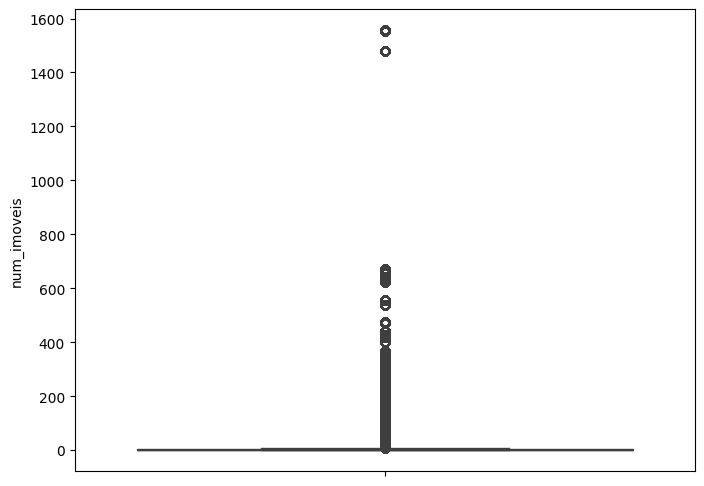

Outliers:


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
470,0012468c364597420246e2b93c1bf25c,02ae88b359eeffea875350beaddc7871,1575de65fb21da62,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
471,0012468c364597420246e2b93c1bf25c,07c521e52c58109890ecf5aaf6be6eb7,14814b153d9e8c73,2023.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,212327.07,1.0,2.0,0.0,0.0,1.0,0.818182,0.0,1.0
472,0012468c364597420246e2b93c1bf25c,0863160c5551f63d90ecf5aaf6be6eb7,061edf5275eda635,2023.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,212327.07,1.0,2.0,0.0,0.0,1.0,0.818182,0.0,1.0
473,0012468c364597420246e2b93c1bf25c,0a9df4ff10ccdcef875350beaddc7871,2033a08e3acfca9f,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
474,0012468c364597420246e2b93c1bf25c,0c48d2f3896c220f875350beaddc7871,ea5b8028d92162db,2022.0,42.0,0.00,TERRENO,1,DOIS UNIDOS,44.0,...,0.00,111601.39,2.0,1.0,1.0,0.0,1.0,0.818182,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923868,ffe2b729d58e3cf31603ecd7ff6be21f,d85043974e18dd1f875350beaddc7871,e76306b7bf58d1d5,2022.0,47.0,102.50,APARTAMENTO,0,BOA VIAGEM,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0
1923869,ffe2b729d58e3cf31603ecd7ff6be21f,df09fab2e86ab22790ecf5aaf6be6eb7,9a0f325734f358ea,2023.0,52.0,81.00,APARTAMENTO,0,SANTO AMARO,18.0,...,56522.59,58830.77,1.0,10.0,0.0,0.2,1.0,0.818182,1.0,1.0
1923872,ffe2b729d58e3cf31603ecd7ff6be21f,eb4591d0f8598954875350beaddc7871,755dafe96cc7869b,2022.0,52.0,81.00,APARTAMENTO,0,SANTO AMARO,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0
1923873,ffe2b729d58e3cf31603ecd7ff6be21f,ef608fc8e60735d6875350beaddc7871,ab455834b4d86772,2022.0,64.0,101.73,CASA,0,CAMPO GRANDE,18.0,...,37538.14,38529.94,2.0,9.0,1.0,0.1,1.0,0.818182,1.0,1.0


In [695]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='num_imoveis', data=feature_store_credito)
plt.show()

# IQR
Q1 = feature_store_credito['num_imoveis'].quantile(0.25)
Q3 = feature_store_credito['num_imoveis'].quantile(0.75)
IQR = Q3 - Q1

# limites para identificar outliers
limite_inferior = Q1 - 3.0 * IQR
limite_superior = Q3 + 3.0 * IQR

# outliers
outliers = feature_store_credito[(feature_store_credito['num_imoveis'] < limite_inferior) | (feature_store_credito['num_imoveis'] > limite_superior)]

print("Outliers:")
outliers

# CORRELAÇÃO LINEAR

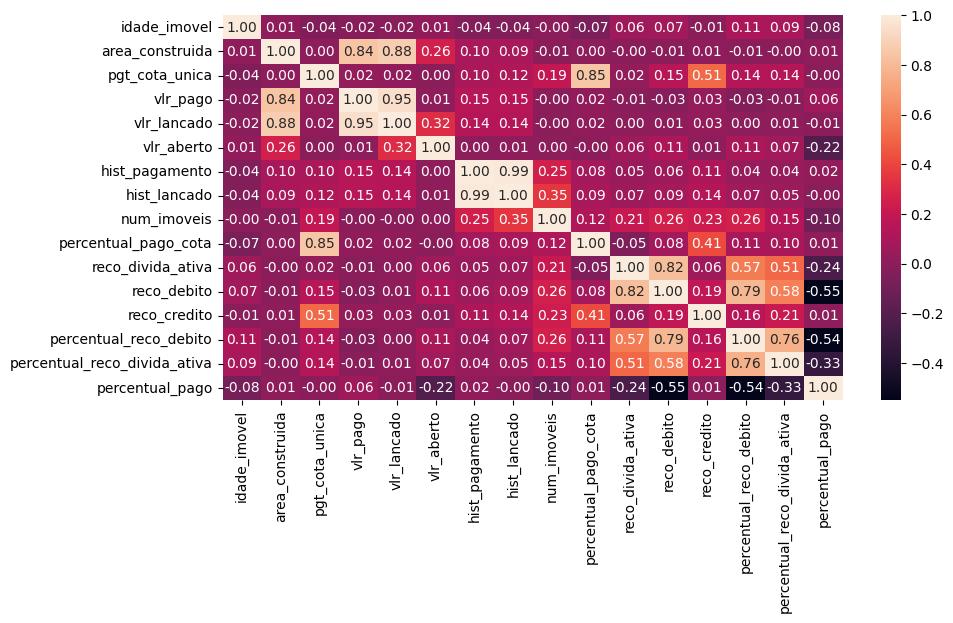

In [54]:
matriz_correlacao = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# CORRELAÇÃO NÃO LINEAR

In [55]:
from scipy.stats import spearmanr

matriz_correlacao_rank = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'percentual_pago_cota',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_reco_debito',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr(method='spearman')
matriz_correlacao_rank

,idade_imovel,area_construida,pgt_cota_unica,vlr_pago,vlr_lancado,vlr_aberto,hist_pagamento,hist_lancado,num_imoveis,percentual_pago_cota,reco_divida_ativa,reco_debito,reco_credito,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
idade_imovel,1.000000,-0.023601,-0.048350,-0.247712,-0.240319,0.072844,-0.180021,-0.168815,-0.080502,-0.055979,0.054098,0.073963,-0.009929,0.104648,0.099198,-0.079469
area_construida,-0.023601,1.000000,-0.051767,0.681390,0.809275,-0.033644,0.232288,0.242701,-0.142347,-0.049836,-0.100421,-0.131304,-0.013038,-0.136417,-0.105314,0.064436
pgt_cota_unica,-0.048350,-0.051767,1.000000,0.042282,0.037258,-0.005006,0.302807,0.291529,0.239094,0.952005,0.019179,0.114388,0.492376,0.120261,0.127769,0.000820
vlr_pago,-0.247712,0.681390,0.042282,1.000000,0.773887,-0.495322,0.477256,0.400202,0.031896,0.045279,-0.181726,-0.322873,0.110365,-0.308351,-0.217954,0.512318
vlr_lancado,-0.240319,0.809275,0.037258,0.773887,1.000000,0.069519,0.433769,0.472734,0.024919,0.043345,-0.048050,-0.037917,0.110555,-0.049667,-0.030046,-0.033695
vlr_aberto,0.072844,-0.033644,-0.005006,-0.495322,0.069519,1.000000,-0.162006,-0.005496,-0.008983,0.002351,0.221738,0.529276,0.003130,0.479081,0.334021,-0.994618
hist_pagamento,-0.180021,0.232288,0.302807,0.477256,0.433769,-0.162006,1.000000,0.961376,0.740752,0.293191,0.151312,0.127608,0.573247,0.112310,0.117853,0.174076
hist_lancado,-0.168815,0.242701,0.291529,0.400202,0.472734,-0.005496,0.961376,1.000000,0.762521,0.281193,0.201541,0.230424,0.565937,0.224804,0.208573,0.019897
num_imoveis,-0.080502,-0.142347,0.239094,0.031896,0.024919,-0.008983,0.740752,0.762521,1.000000,0.218932,0.315276,0.326109,0.341458,0.310302,0.274605,0.005982
percentual_pago_cota,-0.055979,-0.049836,0.952005,0.045279,0.043345,0.002351,0.293191,0.281193,0.218932,1.000000,-0.015125,0.103577,0.503117,0.114676,0.117827,-0.005827


---

## INCLUINDO A NATUREZA JURÍDICA OU FÍSICA DO CONTRIBUINTE

In [49]:
arq_natureza = r'C:\Users\Acer\Projetos\Recife\dados\querys_modelos\RELACAO_IMOVEL_TIPO_CONTRIBUINTE.xlsx'
tbl_pf_pj = pd.read_excel(arq_natureza)
tbl_pf_pj 

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,PF
1,200d024ed1d1cc90,PJ
2,730b78533133f903,PJ
3,408002743410a58c,PJ
4,b7e964d611a3baa8,PF
...,...,...
517851,42e13a28e98c6be0,PF
517852,4b1a9413a179e1ea,PF
517853,6e3c9674c93ba1eb,PF
517854,b9e1dd322b5fbe3e,PF


In [50]:
tbl_pf_pj['tipo_contribuinte'] = tbl_pf_pj['tipo_contribuinte'].replace({'PF': 1, 'PJ': 0})
tbl_pf_pj

,id_imovel,tipo_contribuinte
0,6b3a8e268c80aedf,1
1,200d024ed1d1cc90,0
2,730b78533133f903,0
3,408002743410a58c,0
4,b7e964d611a3baa8,1
...,...,...
517851,42e13a28e98c6be0,1
517852,4b1a9413a179e1ea,1
517853,6e3c9674c93ba1eb,1
517854,b9e1dd322b5fbe3e,1


In [51]:
feature_store_credito = pd.merge(feature_store_credito, tbl_pf_pj, on='id_imovel', how='left')
feature_store_credito

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,721.31,3339.77,1.0,3.0,0.0,0.0,1.0,0.6,0.0,1.0
1,0000398c485f8b42344d77602867ec09,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,2017.0,55.0,110.15,1,CASA,AREIAS,0,...,721.31,721.31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,721.31,2100.81,2.0,2.0,1.0,0.0,1.0,0.6,0.0,1.0
3,00003a695da4777aec557718ffae83ea,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,2020.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924713,ffffe7d2325d80e6d8b209292c0ce31d,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,2021.0,15.0,93.60,1,CASA,COHAB,0,...,5944.02,5944.02,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
1924714,ffffe7d2325d80e6d8b209292c0ce31d,807e85a93b8584ca11babe4a46e18b6d,233f75a5f20edef9,2018.0,15.0,93.60,1,CASA,COHAB,0,...,4082.82,4082.82,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0
1924715,ffffe7d2325d80e6d8b209292c0ce31d,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,2020.0,15.0,93.60,1,CASA,COHAB,0,...,5310.62,5310.62,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0
1924716,ffffe7d2325d80e6d8b209292c0ce31d,d3d0e5512a43a626e08920064611a7cf,233f75a5f20edef9,2017.0,15.0,93.60,1,CASA,COHAB,0,...,3512.62,3512.62,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


## Acompanhamento da quantidade de registros em cada recorte

In [52]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2022')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [53]:
ate_21 = feature_store_credito_ate_21.shape[0]
ano_22 = feature_store_credito_22.shape[0]
ano_23 = feature_store_credito_23.shape[0]
ano_22_23 = feature_store_credito_22_23.shape[0]
print(f'O número de registros em feature_store_credito_ate_22 é: {ate_21}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_23}')
print(f'O número de registros em feature_store_credito_ate_22 é: {ano_22_23}')

O número de registros em feature_store_credito_ate_22 é: 1239278
O número de registros em feature_store_credito_ate_22 é: 340659
O número de registros em feature_store_credito_ate_22 é: 344781
O número de registros em feature_store_credito_ate_22 é: 685440


# PERFIL DA BASE

In [54]:
pagaram = feature_store_credito_22_23.query('vlr_pago == vlr_lancado')
nao_pagaram = feature_store_credito_22_23.query('vlr_pago == 0')
pagaram_parcialmente = feature_store_credito_22_23.query('(vlr_pago > 0) & (vlr_pago < vlr_lancado)')

In [55]:
pagaram = pagaram.copy()
nao_pagaram = nao_pagaram.copy()
pagaram_parcialmente = pagaram_parcialmente.copy()

pagaram['contagem'] = 1
nao_pagaram['contagem'] = 1
pagaram_parcialmente['contagem'] = 1

contagem_pagaram_por_ano = pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_nao_pagaram_por_ano = nao_pagaram.groupby('ano')['contagem'].count().reset_index()
contagem_pagaram_parcialmente_por_ano = pagaram_parcialmente.groupby('ano')['contagem'].count().reset_index()

contagem_pagaram_por_ano.columns = ['ano', 'pagaram']
contagem_nao_pagaram_por_ano.columns = ['ano', 'nao_pagaram']
contagem_pagaram_parcialmente_por_ano.columns = ['ano', 'pagaram_parcialmente']

perfil_base_ate_21_por_ano = pd.merge(contagem_pagaram_por_ano, contagem_nao_pagaram_por_ano, on='ano', how='outer')
perfil_base_ate_21_por_ano = pd.merge(perfil_base_ate_21_por_ano, contagem_pagaram_parcialmente_por_ano, on='ano', how='outer')

perfil_base_ate_21_por_ano = perfil_base_ate_21_por_ano.fillna(0)
perfil_base_ate_21_por_ano['total'] = perfil_base_ate_21_por_ano['pagaram'] + perfil_base_ate_21_por_ano['nao_pagaram'] + perfil_base_ate_21_por_ano['pagaram_parcialmente']

perfil_base_ate_21_por_ano

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2022.0,243504,77986,19169,340659
1,2023.0,226948,85583,32250,344781


In [56]:
totais_df_percentuais = perfil_base_ate_21_por_ano.copy()
totais_df_percentuais['pagaram'] = (totais_df_percentuais['pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['nao_pagaram'] = (totais_df_percentuais['nao_pagaram'] / totais_df_percentuais['total']) * 100
totais_df_percentuais['pagaram_parcialmente'] = (totais_df_percentuais['pagaram_parcialmente'] / totais_df_percentuais['total']) * 100
totais_df_percentuais

,ano,pagaram,nao_pagaram,pagaram_parcialmente,total
0,2022.0,71.480278,22.892687,5.627035,340659
1,2023.0,65.823813,24.822424,9.353764,344781


### Nos anos de 2017 a 2021 
* Adimplencia era em média de 94.53% 
* Inadimplência era em média de 3% 
* Pagantes parciais era em média de 2.55%

### Nos anos de 2022 a 2023 
* Adimplencia era em média de 68.65% 
* Inadimplência era em média de 23.85% 
* Pagantes parciais era em média de 7.49%

## Filtrando dados para baseline

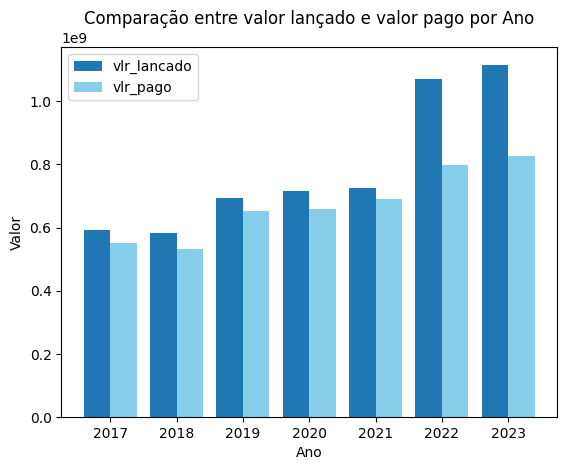

In [57]:
agrupado_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

plt.bar(agrupado_por_ano['ano'] - 0.2, agrupado_por_ano['vlr_lancado'], width=0.4, label='vlr_lancado')
plt.bar(agrupado_por_ano['ano'] + 0.2, agrupado_por_ano['vlr_pago'], width=0.4, label='vlr_pago', color='skyblue')

plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Comparação entre valor lançado e valor pago por Ano')
plt.legend()

plt.show()

In [58]:
somas_por_ano = feature_store_credito.groupby('ano')[['vlr_lancado', 'vlr_pago']].sum().reset_index()

somas_por_ano['inadimplência'] = somas_por_ano['vlr_lancado'] - somas_por_ano['vlr_pago']

somas_por_ano['vlr_lancado'] = somas_por_ano['vlr_lancado'].apply(formatar_moeda)
somas_por_ano['vlr_pago'] = somas_por_ano['vlr_pago'].apply(formatar_moeda)
somas_por_ano['inadimplência'] = somas_por_ano['inadimplência'].apply(formatar_moeda)

somas_por_ano

,ano,vlr_lancado,vlr_pago,inadimplência
0,2017.0,"R$ 592.553.864,77","R$ 551.234.575,06","R$ 41.319.289,71"
1,2018.0,"R$ 582.440.277,24","R$ 531.344.393,52","R$ 51.095.883,72"
2,2019.0,"R$ 693.120.621,01","R$ 651.620.963,67","R$ 41.499.657,34"
3,2020.0,"R$ 716.287.478,50","R$ 659.326.370,17","R$ 56.961.108,33"
4,2021.0,"R$ 723.873.616,30","R$ 691.095.505,89","R$ 32.778.110,41"
5,2022.0,"R$ 1.069.833.144,91","R$ 798.497.503,17","R$ 271.335.641,74"
6,2023.0,"R$ 1.116.346.835,50","R$ 825.307.393,68","R$ 291.039.441,82"


In [ ]:
# dezessete = contribuinte.query('ano == 2017')
df_dam.query('id_imovel == "d0e8a18b0409a8f2"')
# .query('id_contribuinte == "4c375f5fe6f11e99cd124eb8021f7dca"')

### CONTEXTO DO IMÓVEL

In [59]:
contribuinte = feature_store_credito.groupby(['id_contribuinte','id_imovel', 'ano']).agg({
    'vlr_aberto': 'sum',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum',
    'vlr_aberto': 'sum',
    'pgt_cota_unica': 'first',
    'hist_cota_unica': 'first',
    'hist_pagamento': 'first',
    'hist_lancado': 'first',
    'reco_debito': 'first',
    'reco_credito': 'first',
    'reco_divida_ativa': 'first',
    'percentual_pago_cota': 'first',
    'percentual_reco_debito': 'first',
    'percentual_reco_divida_ativa': 'first',
    'percentual_pago': 'first'
}).reset_index()

Analisando comportamento dos imóveis que estão presentes em todos os anos

In [60]:
contribuintes_em_todos_os_anos = set(contribuinte.groupby('id_imovel')['ano'].nunique()[lambda x: x == len(contribuinte['ano'].unique())].index)
contribuinte_em_todos_os_anos = contribuinte[contribuinte['id_imovel'].isin(contribuintes_em_todos_os_anos)]
contribuinte_em_todos_os_anos.query('id_imovel == "6b7e2fa2f4f1a593"')

,id_contribuinte,id_imovel,ano,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago
3,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2017.0,0.0,1453.81,1453.81,0.0,0.0,2668.51,2668.51,0.0,2.0,0.0,0.0,0.0,0.0,1.0
4,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2018.0,0.0,1486.60,1486.60,0.0,0.0,4155.11,4155.11,0.0,3.0,0.0,0.0,0.0,0.0,1.0
5,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2019.0,0.0,1547.20,1547.20,0.0,0.0,5702.31,5702.31,0.0,4.0,0.0,0.0,0.0,0.0,1.0
6,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2020.0,0.0,1579.00,1579.00,0.0,0.0,7281.31,7281.31,0.0,5.0,0.0,0.0,0.0,0.0,1.0
7,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2021.0,0.0,1633.00,1633.00,0.0,0.0,8914.31,8914.31,0.0,6.0,0.0,0.0,0.0,0.0,1.0
8,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2022.0,0.0,1798.10,1798.10,0.0,0.0,10712.41,10712.41,0.0,7.0,0.0,0.0,0.0,0.0,1.0
9,00003a695da4777aec557718ffae83ea,6b7e2fa2f4f1a593,2023.0,0.0,1904.40,1904.40,0.0,0.0,12616.81,12616.81,0.0,8.0,0.0,0.0,0.0,0.0,1.0


In [61]:
analise_contribuinte = contribuinte_em_todos_os_anos.groupby('ano').agg({
    'id_imovel': 'nunique',
    'vlr_pago': 'sum',
    'vlr_lancado': 'sum'
}).reset_index()


analise_contribuinte['percentual_pago'] = (analise_contribuinte['vlr_pago'] / analise_contribuinte['vlr_lancado']) * 100

analise_contribuinte = analise_contribuinte.sort_values(by='ano')

# Aumento do valor lançado
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['vlr_lancado'].diff()
analise_contribuinte['aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte['percentual_aumento_valor_lancado'] = (analise_contribuinte['vlr_lancado'].diff() / analise_contribuinte['vlr_lancado'].shift()) * 100
analise_contribuinte['percentual_aumento_valor_lancado'].fillna(0, inplace=True)
analise_contribuinte.columns = ['ano', 'id_imovel', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'aumento_valor_lancado', 'percentual_aumento_valor_lancado']

analise_contribuinte['vlr_lancado'] = analise_contribuinte['vlr_lancado'].apply(formatar_moeda)
analise_contribuinte['aumento_valor_lancado'] = analise_contribuinte['aumento_valor_lancado'].apply(formatar_moeda)
analise_contribuinte['vlr_pago'] = analise_contribuinte['vlr_pago'].apply(formatar_moeda)
analise_contribuinte

,ano,id_imovel,vlr_pago,vlr_lancado,percentual_pago,aumento_valor_lancado,percentual_aumento_valor_lancado
0,2017.0,177815,"R$ 408.001.720,20","R$ 430.298.828,14",94.818227,"R$ 0,00",0.000000
1,2018.0,177815,"R$ 436.063.375,00","R$ 455.398.597,13",95.754220,"R$ 25.099.768,99",5.833102
2,2019.0,177815,"R$ 465.514.580,95","R$ 480.130.707,55",96.955803,"R$ 24.732.110,42",5.430871
3,2020.0,177815,"R$ 473.775.890,29","R$ 497.247.631,34",95.279668,"R$ 17.116.923,79",3.565055
4,2021.0,177815,"R$ 498.844.637,43","R$ 513.152.867,98",97.211702,"R$ 15.905.236,64",3.198655
5,2022.0,177815,"R$ 545.946.656,14","R$ 567.796.935,79",96.151744,"R$ 54.644.067,81",10.648692
6,2023.0,177815,"R$ 558.817.634,90","R$ 603.661.002,95",92.571432,"R$ 35.864.067,16",6.316354


* Segundo prefeitura de Recife em 2022 obteve um aumento de 10,67% no valor do IPTU cobrado com o aumento do IPCA (Índice de preços ao consumidor amplo)
* Isso é refletido nos dados observando a evolução dos mesmos imóveis entre 2017 e 2023 no ano de 2022 de 10.64%

## Novos imóveis - A cada ano os imóveis que não aparecem nos anos anteriores

In [62]:
analise = pd.DataFrame(contribuinte)
contagem_total = []
contagem_novos = []

imoveis_unicos_globais = set()

for ano in range(2017, 2024):
    df_ano_atual = analise[analise['ano'] == ano]
    
    imoveis_unicos_ano_atual = set(df_ano_atual['id_imovel'])
    contagem_total.append(len(imoveis_unicos_ano_atual))

    imoveis_novos = imoveis_unicos_ano_atual - imoveis_unicos_globais
    contagem_novos.append(len(imoveis_novos))
    
    imoveis_unicos_globais.update(imoveis_unicos_ano_atual)

contagem_df = pd.DataFrame({'Ano': list(range(2017, 2024)),
                            'Total': contagem_total,
                            'Novos': contagem_novos})
contagem_df

,Ano,Total,Novos
0,2017,245823,245823
1,2018,232195,21313
2,2019,257048,12600
3,2020,253155,7211
4,2021,249509,5532
5,2022,340544,53103
6,2023,344677,2667


In [63]:
(21313+12600+7211+5532+53103) / 5

19951.8

### Verificação de imóveis novos em relação ao ano anterior

In [71]:
contra_prova = pd.DataFrame(contribuinte)

df_2021 = contra_prova[contra_prova['ano'] == 2018]
df_2022 = contra_prova[contra_prova['ano'] == 2019]
imoveis_unicos_2021 = set(df_2021['id_imovel'])
imoveis_unicos_2022 = set(df_2022['id_imovel'])

imoveis_novos_2022 = imoveis_unicos_2022 - imoveis_unicos_2021
quantidade_imoveis_novos_2022 = len(imoveis_novos_2022)

print(f"Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: {quantidade_imoveis_novos_2022}")

Quantidade de imóveis únicos em 2022 que não estavam presentes em 2021: 38423


### Descritivo dos registros que apareceram em 2022 e não apareceram nos anos anteriores

In [64]:
ano_interesse = 2022

id_imoveis_ano_interesse = set(feature_store_credito[feature_store_credito['ano'] == ano_interesse]['id_imovel'])
id_imoveis_anos_anteriores = set(feature_store_credito[feature_store_credito['ano'] < ano_interesse]['id_imovel'])

id_imoveis_novos_2022 = id_imoveis_ano_interesse - id_imoveis_anos_anteriores

registros_imoveis_novos_2022 = feature_store_credito[(feature_store_credito['ano'] == ano_interesse) & (feature_store_credito['id_imovel'].isin(id_imoveis_novos_2022))]
registros_imoveis_novos_2022

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
124,000554c5705b8f31be91dcec7d89e48e,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,2022.0,37.0,227.00,1,CASA,SANCHO,1,...,369.82,3634.09,2.0,3.0,1.0,0.000,1.0,0.818182,0.0,1.0
125,000554c5705b8f31be91dcec7d89e48e,3d2d5ea17fa2abb6875350beaddc7871,0fd2704b768f5ec1,2022.0,37.0,50.00,1,CASA,TEJIPIO,1,...,369.82,3634.09,2.0,3.0,1.0,0.000,1.0,0.818182,0.0,1.0
158,000627afce004bd2d4613fe022d53698,1a49f9493c4502c0875350beaddc7871,5c7d6bee95365501,2022.0,53.0,41.29,1,APARTAMENTO,BOA VISTA,1,...,0.00,427.44,2.0,1.0,1.0,0.000,1.0,0.750000,0.0,1.0
238,000a0685733c58fcd8b209292c0ce31d,a13b51bb2cc26ca5875350beaddc7871,d199dbe03307c331,2022.0,41.0,55.00,1,APARTAMENTO,MUSTARDINHA,1,...,0.00,386.27,2.0,1.0,1.0,0.000,1.0,0.818182,0.0,1.0
256,000af8d8be6de7c31db4804237c116dd,d8dcda5a0bcbf2db875350beaddc7871,9592dd651ab79d8b,2022.0,40.0,82.25,1,APARTAMENTO,AREIAS,0,...,1513.43,1513.43,1.0,2.0,1.0,0.000,1.0,0.800000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924482,fff5f3d945bfe3d076beb59f44c20df3,f5bec795df55fd24875350beaddc7871,ea575e456771ef38,2022.0,35.0,70.00,1,CASA,BONGI,1,...,2973.15,4724.20,2.0,6.0,1.0,0.000,1.0,0.818182,0.0,1.0
1924523,fff8aff6848c2d188e79cf1867e8cc19,e9059839361d3967875350beaddc7871,40f5c4dc59762a58,2022.0,31.0,54.50,1,APARTAMENTO,VARZEA,1,...,14599.25,18209.18,2.0,7.0,1.0,0.125,1.0,0.800000,0.0,1.0
1924532,fff9325728d059d81603ecd7ff6be21f,b23dba1130b282db875350beaddc7871,b3503af7cfe8182f,2022.0,40.0,71.47,1,APARTAMENTO,AREIAS,1,...,0.00,2160.17,2.0,3.0,1.0,0.000,1.0,0.714286,0.0,1.0
1924575,fffafcbc80a2ab2a1603ecd7ff6be21f,5cca6bf618589050875350beaddc7871,c79c2476626fa4b6,2022.0,33.0,60.00,1,CASA,BREJO DA GUABIRABA,1,...,35845.37,37570.46,2.0,7.0,1.0,0.000,1.0,0.777778,0.0,1.0


In [65]:
registros_imoveis_novos_2022.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel,tipo_propriedade,bairro
count,53103,53103,53103,53103,53103
unique,35649,53103,53103,19,94
top,878ed023fa473bede000edc2a2086273,222265876522c289875350beaddc7871,5f537f5f4c7b5d64,CASA,BOA VIAGEM
freq,910,1,1,21896,4303


In [66]:
individuo_devedor = registros_imoveis_novos_2022.query('id_contribuinte =="878ed023fa473bede000edc2a2086273"')
individuo_devedor

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte
1008347,878ed023fa473bede000edc2a2086273,0007800e7f730279875350beaddc7871,e41e0edbe3db3d28,2022.0,38.0,151.84,1,CASA,ENGENHO DO MEIO,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1008352,878ed023fa473bede000edc2a2086273,006aa2b2501876b5875350beaddc7871,05b5f6c7fe9b6d62,2022.0,20.0,64.05,1,APARTAMENTO,SANCHO,0,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,1.0,0.0
1008357,878ed023fa473bede000edc2a2086273,00c4518a157926a8875350beaddc7871,dd59b6cabf35c493,2022.0,20.0,64.05,1,APARTAMENTO,SANCHO,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1008370,878ed023fa473bede000edc2a2086273,015def34d902f246875350beaddc7871,e96d62aa1f3e5867,2022.0,30.0,0.00,0,TERRENO,BREJO DA GUABIRABA,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1008385,878ed023fa473bede000edc2a2086273,01daaf0f87c3082d875350beaddc7871,0ce86f63a46a2d44,2022.0,51.0,149.44,1,CASA,JARDIM SAO PAULO,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014088,878ed023fa473bede000edc2a2086273,fe6ca9eb82e66c7d875350beaddc7871,e48a0eb3a0703e1f,2022.0,40.0,0.00,0,TERRENO,COHAB,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1014090,878ed023fa473bede000edc2a2086273,fe7cdd4987651229875350beaddc7871,acb1be9566e665ae,2022.0,35.0,180.00,1,CASA,COHAB,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1014110,878ed023fa473bede000edc2a2086273,ff7f88a7deb7cc72875350beaddc7871,264ba5bc21db1d93,2022.0,41.0,650.00,1,APARTAMENTO,COHAB,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0
1014112,878ed023fa473bede000edc2a2086273,ff884d10f09c4dfc875350beaddc7871,a4b037ae38bd4e15,2022.0,40.0,0.00,0,TERRENO,COHAB,1,...,1936637.57,6347461.75,2.0,10.0,1.0,0.090909,1.0,0.5625,0.0,0.0


In [443]:
formatar_moeda(individuo_devedor['vlr_lancado'].sum())

'R$ 1.566.325,78'

In [444]:
formatar_moeda(individuo_devedor['vlr_pago'].sum())

'R$ 13.562,73'

---

# INICIANDO CONSTRUÇÃO DO MODELO

# Seleção de variáveis

In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]


In [68]:
feature_store_credito['perc_hist_pago'] = (feature_store_credito['hist_pagamento'] / feature_store_credito['hist_lancado']).fillna(0)

In [69]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago'],
      dtype='object')

In [70]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'tipo_contribuinte', 'percentual_pago',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

KeyError: "['perc_hist_pago', 'tipo_propriedade_encoded'] not in index"

# São 479 registros de 77 contribuintes em que não há histórico para os mesmos

In [ ]:
variaveis_selecionadas.isnull().sum()

idade_imovel                      0
num_imoveis                       0
natureza_imovel                   0
reco_credito                      0
perc_hist_pago                    0
percentual_reco_debito            0
percentual_pago_cota              0
reco_divida_ativa                 0
percentual_reco_divida_ativa      0
tipo_contribuinte               226
percentual_pago                   0
tipo_propriedade_encoded          0
dtype: int64

In [ ]:
variaveis_selecionadas.query('tipo_contribuinte.isnull()')

,idade_imovel,num_imoveis,natureza_imovel,reco_credito,perc_hist_pago,percentual_reco_debito,percentual_pago_cota,reco_divida_ativa,percentual_reco_divida_ativa,tipo_contribuinte,percentual_pago,tipo_propriedade_encoded
8660,54.0,1.0,1,3.0,1.000000,1.000000,0.000000,1.0,1.000000,NaN,1.0,1
15894,25.0,5.0,1,10.0,0.985429,0.181818,0.090909,0.0,0.333333,NaN,1.0,13
19425,24.0,1.0,1,4.0,0.645296,0.800000,0.000000,1.0,0.600000,NaN,0.0,1
21595,27.0,1.0,1,8.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,17
22129,36.0,1.0,1,2.0,0.172127,1.000000,0.000000,1.0,0.818182,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1850759,22.0,1.0,1,7.0,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1.0,0
1859674,14.0,1.0,1,7.0,1.000000,0.000000,0.125000,0.0,0.000000,NaN,1.0,0
1902610,40.0,1.0,0,1.0,0.000000,1.000000,0.000000,1.0,0.818182,NaN,0.0,19
1904339,37.0,1.0,1,2.0,0.139083,1.000000,0.000000,1.0,0.777778,NaN,0.0,0


In [ ]:
variaveis_selecionadas = variaveis_selecionadas.dropna(subset=['tipo_contribuinte'])

In [ ]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
tipo_contribuinte               0
percentual_pago                 0
tipo_propriedade_encoded        0
dtype: int64

# REGRESSÃO LINEAR UTILIZANDO XGBOOST E RANDOM FOREST

In [ ]:
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa',
       'tipo_contribuinte', 'percentual_pago', 'tipo_propriedade_encoded'],
      dtype='object')

In [ ]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [ ]:
variaveis_selecionadas['percentual_pago'].mean()

0.7405909801142553

In [ ]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [ ]:
x.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa',
       'tipo_contribuinte', 'tipo_propriedade_encoded'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.4)

In [ ]:
X_train.shape[0]
1112477

1112477

### COEFICIENTE DE CONCORDÂNCIA DE LIN, AVALIA A CONCORDÂNCIA ENTRE AS PREVISÕES E OS VALORES OBSERVADO (REAIS)

In [ ]:
def ccc_score(y_true, y_pred):
    rho = np.corrcoef(y_true, y_pred)[0, 1] # calcula o coeficiente de pearson entre valores reais e os valores preditos/ 0 e 1 acessa a matriz
    std_true = np.std(y_true)               # calcula o desvio padrao dos valores reais
    std_pred = np.std(y_pred)               # calcula o desvio padrão das previsões do modelo 
    mean_true = np.mean(y_true)             # calcula a média dos valores reais
    mean_pred = np.mean(y_pred)             # calcula a média das previsões do modelo
    
    # fórmula do índice de concordância de Lin
    # O índice de concordância de Lin avalia a concordância entre as previsões do modelo (y_pred) e os valores reais (y_true)
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

### PIPELINE CALCULANDO:

R2 - o R² ajuda a entender quão bem o modelo se ajusta aos dados, mede a proporção da variabilidade na variável dependente que é explicada pelo modelo de regressão.

RMSE - O RMSE mede a média da diferença entre os valores previstos pelo modelo e os valores reais, mede a precisão das previsões individuais, indicando o quão bem o modelo se comporta em termos absolutos.

CCC - O CCC avalia a concordância relativa entre a variabilidade dos valores reais e preditos, levando em conta a diferença média entre eles

In [ ]:
def roda_pipeline(algoritmo_normalizador, algoritmo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritmo_normalizador), ('regressor', algoritmo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = np.sqrt(mean_squared_error(y_test, previsoes))
    ccc = ccc_score(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritmo_regressao))
    print("R2 ->", r2)
    print("RMSE ->", mse)
    print("CCC ->", ccc)

XGBOOST

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.02,
    'min_child_weight': 3,
    'n_estimators': 2000,
    'colsample_bynode': 1,
    'subsample': 0.9
}

biblioteca_modelos_xgboost = {
    'dummy': DummyRegressor(),
    'xgboost': XGBRegressor(**params, random_state=1337)
}

pipeline_modelo_xgboost = ['dummy', 'xgboost']

RANDOMFOREST

In [ ]:
biblioteca_modelos_random_forest = {
    'dummy': DummyRegressor(),
    'random_forest': RandomForestRegressor(random_state=1337)
}
pipeline_modelo_random_forest = ['dummy','random_forest']

---

# TESTE DE MODELOS

## RANDOM FOREST

* StandardScaler - Padroniza as features removendo a média e dimensionando para a unidade de desvio padrão.
* Sensível a outliers, pois utiliza a média e o desvio padrão, que podem ser influenciados por valores extremos.

In [112]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7348243499900595
RMSE -> 0.21990550873861678
CCC -> 0.8527569998174435


* RobustScaler - Reduz cada feature subtraindo a mediana e dividindo pelo intervalo interquartil (IQR).
* Robusto a outliers, pois utiliza estatísticas resistentes a valores extremos (mediana e IQR).

In [113]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.734640792440038
RMSE -> 0.21998160609805487
CCC -> 0.8526631861930287


* MinMaxScaler - Escala as features para um intervalo fixo, geralmente entre 0 e 1.
* Sensível a outliers, pois a escala é influenciada pelos valores mínimo e máximo.

In [114]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.7347594273877309
RMSE -> 0.21993242667801902
CCC -> 0.8527380253970226


# XGBOOST

* StandardScaler - Padroniza as features removendo a média e dimensionando para a unidade de desvio padrão.
* Sensível a outliers, pois utiliza a média e o desvio padrão, que podem ser influenciados por valores extremos.

In [115]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, random_state=1337, ...)
R2 -> 0.7491690289846575
RMSE -> 0.21387492361230445
CCC -> 0.8604741073225639


* RobustScaler - Reduz cada feature subtraindo a mediana e dividindo pelo intervalo interquartil (IQR).
* Robusto a outliers, pois utiliza estatísticas resistentes a valores extremos (mediana e IQR).

In [116]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, random_state=1337, ...)
R2 -> 0.7491667101537839
RMSE -> 0.21387591220360117
CCC -> 0.8604729435817724


* MinMaxScaler - Escala as features para um intervalo fixo, geralmente entre 0 e 1.
* Sensível a outliers, pois a escala é influenciada pelos valores mínimo e máximo.

In [117]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.236161690458374e-06
RMSE -> 0.42704183710650145
CCC -> -2.9625166545015275e-31



Modelo treinado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, random_state=1337, ...)
R2 -> 0.7491667101537839
RMSE -> 0.21387591220360117
CCC -> 0.8604729435817724


# Validação cruzada

In [118]:
variaveis_selecionadas['percentual_pago'].std()

0.4273994767605044

### O desvio padrão de 0.42 indica a dispersão dos valores reais da variável percentual_pago ao redor da média. Quanto maior o desvio padrão, mais dispersos estão os valores

In [119]:
from sklearn.model_selection import cross_val_score, KFold

params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.02,
    'min_child_weight': 3,
    'n_estimators': 2000,
    'colsample_bynode': 1,
    'subsample': 0.9
}

model = XGBRegressor(**params)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# validação
cv_results = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error')

# RMSE (Root Mean Squared Error)
rmse_scores = np.sqrt(-cv_results)

print(f'RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')

RMSE Scores: [0.21211098 0.21079269 0.2106068  0.21278643 0.21053302]
Mean RMSE: 0.21136598468287118


### Se o RMSE for significativamente menor que o desvio padrão, isso sugere que o modelo está explicando bem a variabilidade nos dados e está fazendo boas previsões.

* Desvio Padrão = 0.42738745039162895 - 42,73%
* RMSE = 0.21179379216811506 - 21,17%

### um RMSE de 0.22 em relação a um desvio padrão de 0.42 sugere que o modelo está performando relativamente bem

# MODELO IPTU VALIDADO EM AÇÃO

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['bairro_encoded'] = le.fit_transform(feature_store_credito['bairro'])

print("Bairros originais:", feature_store_credito['bairro'].unique())
print("Bairros codificados:", feature_store_credito['bairro_encoded'].unique())

Bairros originais: ['AREIAS ' 'AFLITOS ' 'BOA VIAGEM ' 'BOA VISTA ' 'CORDEIRO '
 'ALTO DO MANDU ' 'SAN MARTIN ' 'CASA AMARELA ' 'PARNAMIRIM ' 'GRACAS '
 'PINA ' 'JARDIM SAO PAULO ' 'SANCHO ' 'TEJIPIO ' 'ENGENHO DO MEIO '
 'ESPINHEIRO ' 'TORROES ' 'ENCRUZILHADA ' 'AGUA FRIA ' 'HIPODROMO '
 'MUSTARDINHA ' 'BEBERIBE ' 'PRADO ' 'CAXANGA ' 'IMBIRIBEIRA ' 'TORRE '
 'FUNDAO ' 'IPSEP ' 'TAMARINEIRA ' 'JORDAO ' 'CAMPO GRANDE '
 'DOIS UNIDOS ' 'MONTEIRO ' 'CACOTE ' 'MACAXEIRA ' 'VARZEA ' 'MADALENA '
 'POCO ' 'IPUTINGA ' 'IBURA ' 'SOLEDADE ' 'SANTO AMARO ' 'CASA FORTE '
 'LINHA DO TIRO ' 'COQUEIRAL ' 'CAMPINA DO BARRETO ' 'ROSARINHO '
 'AFOGADOS ' 'SANTO ANTONIO ' 'BARRO ' 'SANTANA ' 'ARRUDA ' 'JIQUIA '
 'MANGUEIRA ' 'ILHA DO LEITE ' 'CURADO ' 'GUABIRABA ' 'CAJUEIRO '
 'PONTO DE PARADA ' 'BREJO DA GUABIRABA ' 'VASCO DA GAMA ' 'SAO JOSE '
 'PORTO DA MADEIRA ' 'DERBY ' 'APIPUCOS ' 'JAQUEIRA ' 'COHAB ' 'BONGI '
 'BRASILIA TEIMOSA ' 'ILHA DO RETIRO ' 'TOTO ' 'CABANGA '
 'CORREGO DO JENIPAPO ' 'BREJO 

In [52]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

feature_store_credito['tipo_propriedade_encoded'] = le.fit_transform(feature_store_credito['tipo_propriedade'])

print("tipo_propriedade originais:", feature_store_credito['tipo_propriedade'].unique())
print("tipo_propriedade codificados:", feature_store_credito['tipo_propriedade_encoded'].unique())

tipo_propriedade originais: ['CASA' 'APARTAMENTO' 'SALA' 'LOJA' 'TERRENO' 'GARAGEM COMERCIAL'
 'EDIFICAÇÃO ESPECIAL' 'GALPÃO' 'MOCAMBO' 'INDUSTRIA'
 'INSTITUIÇÃO EDUCACIONAL' 'INSTITUIÇÃO FINANCEIRA'
 'CENTRO COMERCIAL/SERVIÇOS' 'HOTEL' 'GALPÃO FECHADO' 'HOSPITAL'
 'TEMPLO RELIGIOSO' 'POSTO DE ABASTECIMENTO' 'LOJA MÚLTIPLA'
 'GARAGEM RESIDENCIAL']
tipo_propriedade codificados: [ 1  0 17 13 19  6  3  4 15 10 11 12  2  9  5  8 18 16 14  7]


In [ ]:
feature_store_credito_ate_21 = feature_store_credito.query('ano < 2021')
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [ ]:
feature_store_credito_22.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded
346496,2d6ae6e5dd1e57efae08d57f53945088,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2022.0,17.0,100.86,1,APARTAMENTO,BOA VIAGEM,0,...,6.0,0.0,0.714286,0.428571,1.0,1.0,1.0,0,0.859312,12


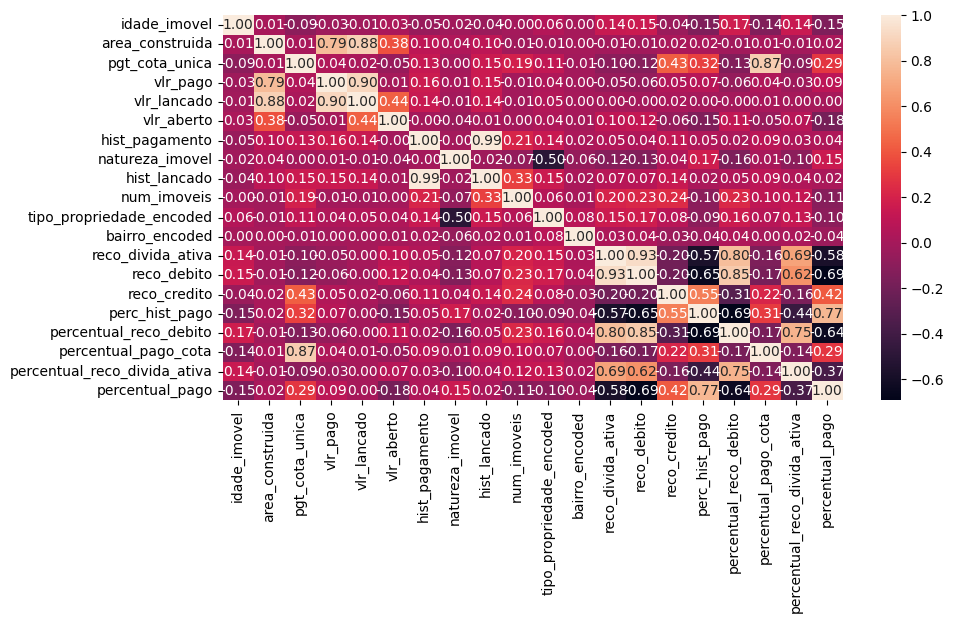

In [ ]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded', 'bairro_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [ ]:
feature_store_credito_22 = feature_store_credito_22.dropna(subset=['tipo_contribuinte'])
feature_store_credito_22.isnull().sum()

id_contribuinte                 0
dam                             0
id_imovel                       0
ano                             0
idade_imovel                    0
area_construida                 0
natureza_imovel                 0
tipo_propriedade                0
bairro                          0
aberto                          0
num_imoveis                     0
vlr_aberto                      0
vlr_pago                        0
vlr_lancado                     0
pgt_cota_unica                  0
hist_cota_unica                 0
hist_pagamento                  0
hist_lancado                    0
reco_debito                     0
reco_credito                    0
reco_divida_ativa               0
percentual_pago_cota            0
percentual_reco_debito          0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_contribuinte               0
tipo_propriedade_encoded        0
perc_hist_pago                  0
bairro_encoded                  0
dtype: int64

In [ ]:
feature_store_credito_22

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded
2,0000398c485f8b42344d77602867ec09,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,2022.0,55.0,110.15,1,CASA,AREIAS,1,...,2.0,1.0,0.000,1.0,0.6,0.0,1.0,1,0.343349,8
4,00003a695da4777aec557718ffae83ea,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,2022.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,0,1.000000,0
11,000046c85d18a6f7968646cfc1e328f2,43f61322c00d0a2a875350beaddc7871,4c440987414316f6,2022.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,0,1.000000,12
20,0000b23be5378f1b8e79cf1867e8cc19,2489dc70da197fd8875350beaddc7871,f4a09ae3e8291db3,2022.0,53.0,28.00,1,SALA,BOA VISTA,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,17,1.000000,13
36,0000b23be5378f1b8e79cf1867e8cc19,d4377c5f6f787b9c875350beaddc7871,e8f779a348c050b1,2022.0,53.0,32.00,1,SALA,BOA VISTA,0,...,7.0,0.0,0.125,0.0,0.0,1.0,1.0,17,1.000000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924685,ffff3836dbf935321bc34267b5521a39,4d78d7f5d9b59641875350beaddc7871,0cfe1aa6943523cf,2022.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,0,1.000000,12
1924693,ffff63826b501d84d8b209292c0ce31d,678b4dd9ca5a91c2875350beaddc7871,e5ef9115acfa782e,2022.0,40.0,213.00,1,CASA,CORDEIRO,0,...,7.0,0.0,0.000,0.0,0.0,1.0,1.0,1,1.000000,31
1924700,ffffc6563e67d8b38e79cf1867e8cc19,473a7619002d4deb875350beaddc7871,18be5a8c332a3892,2022.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,6.0,0.0,0.000,0.0,0.0,1.0,1.0,0,1.000000,52
1924706,ffffc6563e67d8b38e79cf1867e8cc19,d295a8166b764514875350beaddc7871,0fb91ca37fa4509b,2022.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,6.0,0.0,0.000,0.0,0.0,1.0,1.0,0,1.000000,31


# balanceamento dos dados de treino e teste

50% dos meus dados são registros onde tudo foi pago e 50% registros onde não foi pago ou foi pago parcialmente

In [127]:
pg = feature_store_credito_22.query('percentual_pago == 1.0')
npg = feature_store_credito_22.query('percentual_pago == 0.0')
pgparc = feature_store_credito_22.query('(percentual_pago > 0.0) & (percentual_pago < 1.0)')

In [520]:
# estou criando uma Subamostra aleatória dos dados com percentual pago de 1.0
amostra_pagante = feature_store_credito_22[feature_store_credito_22['percentual_pago'] == 1.0].sample(frac=0.03, random_state=42)

# Subamostra aleatória dos dados com percentual pago de 0.0
amostra_nao_pagante = feature_store_credito_22[feature_store_credito_22['percentual_pago'] == 0.0].sample(frac=0.95, random_state=42)

# Combinando com a amostra de pagantes parcialmente
dados_balanceados = pd.concat([amostra_pagante, amostra_nao_pagante, feature_store_credito_22[(feature_store_credito_22['percentual_pago'] > 0.0) & 
                                                                         (feature_store_credito_22['percentual_pago'] < 1.0)]])
dados_balanceados = dados_balanceados.sample(frac=1, random_state=42)

historico de pagamento por imovel do contribuinte

In [152]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
             'tipo_propriedade_encoded', 'bairro_encoded', 'tipo_contribuinte']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
       'tipo_propriedade_encoded', 'bairro_encoded', 'tipo_contribuinte'],
      dtype='object')

In [153]:
variaveis_selecionadas.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340433 entries, 2 to 1924711
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   idade_imovel                  340433 non-null  float64
 1   num_imoveis                   340433 non-null  float64
 2   natureza_imovel               340433 non-null  int64  
 3   reco_credito                  340433 non-null  float64
 4   perc_hist_pago                340433 non-null  float64
 5   percentual_reco_debito        340433 non-null  float64
 6   percentual_pago_cota          340433 non-null  float64
 7   reco_divida_ativa             340433 non-null  float64
 8   percentual_reco_divida_ativa  340433 non-null  float64
 9   percentual_pago               340433 non-null  float64
 10  tipo_propriedade_encoded      340433 non-null  int32  
 11  bairro_encoded                340433 non-null  int32  
 12  tipo_contribuinte             340433 non-nu

In [154]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
percentual_pago                 0
tipo_propriedade_encoded        0
bairro_encoded                  0
tipo_contribuinte               0
dtype: int64

In [155]:
variaveis_selecionadas['percentual_pago'].describe()

count    340433.000000
mean          0.740591
std           0.427399
min           0.000000
25%           0.316071
50%           1.000000
75%           1.000000
max           1.000000
Name: percentual_pago, dtype: float64

In [156]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [157]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

In [158]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [159]:
x_norm = df_normalizado

In [160]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,        # significa que cada árvore no XGBoost pode ter até 10 níveis de decisão
    'learning_rate': 0.02,  # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
    'min_child_weight': 5,  # define a soma mínima dos pesos das instâncias necessária em um nó da árvore para continuar a divisão
    'n_estimators': 1000,   # número total de árvores
    'colsample_bynode': 1,  # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
    'subsample': 0.5,        # 90% das instâncias estão sendo amostradas aleatoriamente
    # 'scale_pos_weight': scale_pos_weight
}


best_model = XGBRegressor(**params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [161]:
previsoes = best_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.7614841096038703
RMSE -> 0.20842968793881278
CCC -> 0.8660597158667647


In [138]:
dummy_model = RandomForestRegressor(random_state=1337)
dummy_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [139]:
previsoes = dummy_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.743085444285082
RMSE -> 0.21631930278770606
CCC -> 0.8569563439047478


# importância das variáveis

In [162]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['idade_imovel' 'num_imoveis' 'natureza_imovel' 'reco_credito'
 'perc_hist_pago' 'percentual_reco_debito' 'percentual_pago_cota'
 'reco_divida_ativa' 'percentual_reco_divida_ativa'
 'tipo_propriedade_encoded' 'bairro_encoded' 'tipo_contribuinte']


In [163]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,perc_hist_pago,0.409367
1,reco_credito,0.100976
2,percentual_reco_divida_ativa,0.096756
3,reco_divida_ativa,0.092184
4,percentual_reco_debito,0.060151
5,percentual_pago_cota,0.049063
6,num_imoveis,0.043651
7,natureza_imovel,0.043085
8,tipo_propriedade_encoded,0.029463
9,idade_imovel,0.026173


# PREVISÕES DO MODELO

In [164]:
df_feature_store_predict = feature_store_credito_23
# df_feature_store_predict = df_feature_store_predict.query('aberto == 0')

In [165]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,3.0,0.0,0.00,1.0,0.6,0.0,1.0,1,0.215976,8
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,8.0,0.0,0.00,0.0,0.0,1.0,1.0,0,1.000000,0
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,0,1.000000,12
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,13
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,13


In [166]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
             'tipo_propriedade_encoded', 'bairro_encoded', 'tipo_contribuinte']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'percentual_pago',
       'tipo_propriedade_encoded', 'bairro_encoded', 'tipo_contribuinte'],
      dtype='object')

In [167]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [168]:
predicao = best_model.predict(x)

In [169]:
df_resultado_predict = feature_store_credito_23
# df_resultado_predict = df_resultado_predict.query('aberto == 0')

# ANÁLISE DE RESÍDUOS

In [ ]:
# Gerando resíduos da predição (observado - previsão)
df_resultado_predict['y_predict'] = predicao
df_resultado_predict['residuos'] =  df_resultado_predict['percentual_pago'] - df_resultado_predict['y_predict']

In [171]:
df_resultado_predict

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,y_predict,residuos
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.000000,1.0,0.6,0.0,1.0,1,0.215976,8,0.190533,-0.190533
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,0,1.001119,-0.001119
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.250000,0.0,0.0,1.0,1.0,0,1.000000,12,1.005234,-0.005234
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,13,0.994759,0.005241
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,13,1.000272,-0.000272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,12,0.999300,0.000700
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,40.0,213.00,1,CASA,CORDEIRO,0,...,0.000000,0.0,0.0,1.0,1.0,1,1.000000,31,1.000170,-0.000170
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,52,0.999609,0.000391
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,31,0.999834,0.000166


In [172]:
# Truncar valores maiores que 1.0 
df_resultado_predict['y_predict'] = df_resultado_predict['y_predict'].clip(upper=1.0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_21752\1433363693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['y_predict'] = df_resultado_predict['y_predict'].clip(upper=1.0)


In [175]:
# Calcular a nova coluna 'suposto_pagamento'
df_resultado_predict['suposto_pagamento'] = df_resultado_predict['y_predict'] * df_resultado_predict['vlr_lancado']

C:\Users\Acer\AppData\Local\Temp\ipykernel_21752\848757003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado_predict['suposto_pagamento'] = df_resultado_predict['y_predict'] * df_resultado_predict['vlr_lancado']


In [180]:
aberto = df_resultado_predict.query('aberto == 0')
aberto = aberto[['dam', 'vlr_aberto', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'y_predict', 'suposto_pagamento']]

In [181]:
formatar_moeda(aberto['vlr_pago'].sum())

'R$ 773.295.993,13'

In [182]:
formatar_moeda(aberto['suposto_pagamento'].sum())

'R$ 732.790.087,46'

In [183]:
formatar_moeda(773295993.13 - 732790087.46)

'R$ 40.505.905,67'

In [184]:
resid = df_resultado_predict[['y_predict', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,y_predict,percentual_pago,residuos
1154950,-0.014711,1.0,1.014711
1851234,-0.009249,1.0,1.009249
1090594,0.007986,1.0,0.992014
1197399,0.015188,1.0,0.984812
1197394,0.015188,1.0,0.984812
...,...,...,...
297285,0.999410,0.0,-0.999410
615643,0.999710,0.0,-0.999710
446006,0.999760,0.0,-0.999760
1668261,0.999954,0.0,-0.999954


In [185]:
df_resultado_predict['percentual_pago'].describe()

count    344781.000000
mean          0.705686
std           0.436508
min           0.000000
25%           0.083479
50%           1.000000
75%           1.000000
max           1.000000
Name: percentual_pago, dtype: float64

In [186]:
df_resultado_predict['y_predict'].describe()

count    344781.000000
mean          0.751803
std           0.332672
min          -0.234624
25%           0.564687
50%           0.959189
75%           1.000000
max           1.000000
Name: y_predict, dtype: float64

In [187]:
def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil 

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [188]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",6776,0.01966
"[-0.75, -0.5)",20904,0.06066
"[-0.5, -0.25)",22122,0.06419
"[-0.25, -0.2)",6878,0.01996
"[-0.2, -0.15)",8052,0.02336
"[-0.15, -0.1)",8224,0.02386
"[-0.1, -0.05)",7264,0.02108
"[-0.05, 0.0)",110675,0.32113
"[0.0, 0.05)",91060,0.26422


In [192]:
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], bins=igr_bins, labels=igr_labels, right=False)

df_summary_residuos = resid.groupby('resid_faixas').agg(
    {'residuos': 'mean', 'percentual_pago': 'mean', 'resid_faixas': 'count'}
).rename(columns={'resid_faixas': 'frequencia'})

df_summary_residuos['perc'] = df_summary_residuos['frequencia'] / df_summary_residuos['frequencia'].sum() * 100
df_summary_residuos

,residuos,percentual_pago,frequencia,perc
resid_faixas,,,,
"[-1.0, -0.75)",-0.834558,0.007076,6776,1.966127
"[-0.75, -0.5)",-0.611502,0.021240,20904,6.065512
"[-0.5, -0.25)",-0.372309,0.089761,22122,6.418928
"[-0.25, -0.2)",-0.224000,0.134747,6878,1.995723
"[-0.2, -0.15)",-0.174635,0.140763,8052,2.336371
"[-0.15, -0.1)",-0.127480,0.159044,8224,2.386279
"[-0.1, -0.05)",-0.072508,0.311415,7264,2.107725
"[-0.05, 0.0)",-0.006462,0.853989,110675,32.113499
"[0.0, 0.05)",0.008292,0.892288,91060,26.422003


In [190]:
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",6776,0.01966
1,"[-0.75, -0.5)",20904,0.06066
2,"[-0.5, -0.25)",22122,0.06419
3,"[-0.25, -0.2)",6878,0.01996
4,"[-0.2, -0.15)",8052,0.02336
5,"[-0.15, -0.1)",8224,0.02386
6,"[-0.1, -0.05)",7264,0.02108
7,"[-0.05, 0.0)",110675,0.32113
8,"[0.0, 0.05)",91060,0.26422
9,"[0.05, 0.1)",13510,0.03920


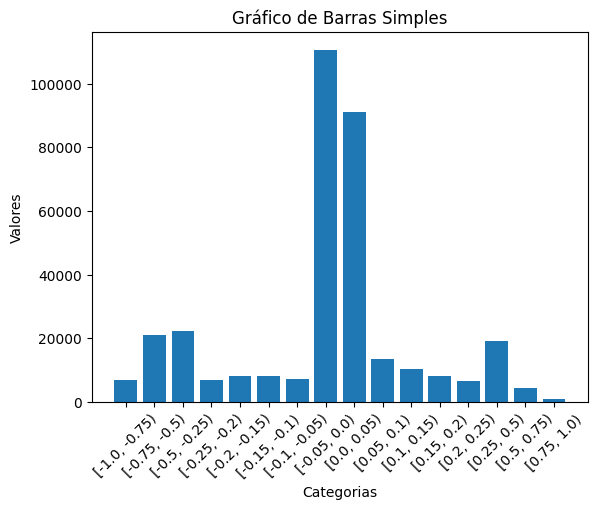

In [191]:
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

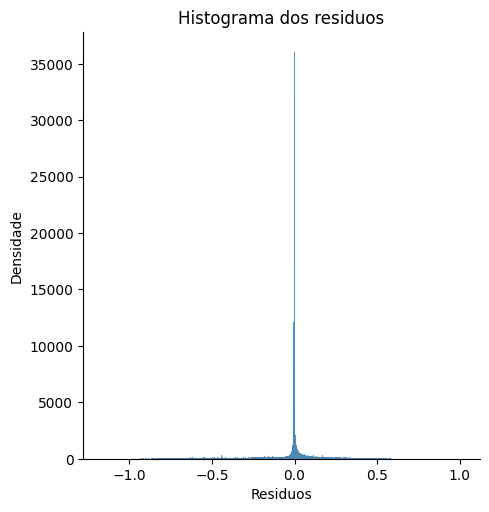

In [193]:
sns.displot(x='residuos', data=feature_store_credito_23)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

# Descritiva de Resíduos

In [194]:
residuos_faixa_erro = df_resultado_predict.query('(residuos >= -1.0) & (residuos <= -0.1)')
residuos_faixa_acerto = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')

In [195]:
teste_residuo = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')
teste_residuo

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,y_predict,residuos,suposto_pagamento
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.000000,0.00,1.0,1.0,17,1.000000,13,0.994759,0.005241,349.637734
38,0000b23be5378f1b8e79cf1867e8cc19,e7b87d7713fd44a490ecf5aaf6be6eb7,f4a09ae3e8291db3,2023.0,53.0,28.00,1,SALA,BOA VISTA,0,...,0.000000,0.00,1.0,1.0,17,1.000000,13,0.994759,0.005241,289.116624
86,00040be7a77b87e0344d77602867ec09,0db3ee4a4e9b9a9890ecf5aaf6be6eb7,9c4e9d06c9acf441,2023.0,38.0,77.88,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.00,1.0,1.0,0,1.000000,12,0.999604,0.000396,1111.739628
130,0005666a0ea59ca7344d77602867ec09,22586b9a1ae588e990ecf5aaf6be6eb7,d5dc1236ac3772cb,2023.0,8.0,73.84,1,APARTAMENTO,ENGENHO DO MEIO,0,...,0.000000,0.00,1.0,1.0,0,1.000000,39,0.999191,0.000809,1254.383990
159,000627afce004bd2d4613fe022d53698,22aa8e376d9d148090ecf5aaf6be6eb7,5c7d6bee95365501,2023.0,53.0,41.29,1,APARTAMENTO,BOA VISTA,1,...,1.000000,0.75,0.0,1.0,0,0.000000,13,-0.013404,0.013404,-4.922233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924682,ffff0e3e56845cdf1603ecd7ff6be21f,cb9019b08c2d102890ecf5aaf6be6eb7,9e35a4e145d6a8bc,2023.0,26.0,84.00,1,CASA,ALTO SANTA TEREZINHA,0,...,0.142857,1.00,1.0,1.0,1,0.845135,6,0.984100,0.015900,634.941541
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.00,1.0,1.0,0,1.000000,12,0.999300,0.000700,5677.851043
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.000000,0.00,1.0,1.0,0,1.000000,52,0.999609,0.000391,746.107886
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.000000,0.00,1.0,1.0,0,1.000000,31,0.999834,0.000166,1786.003370


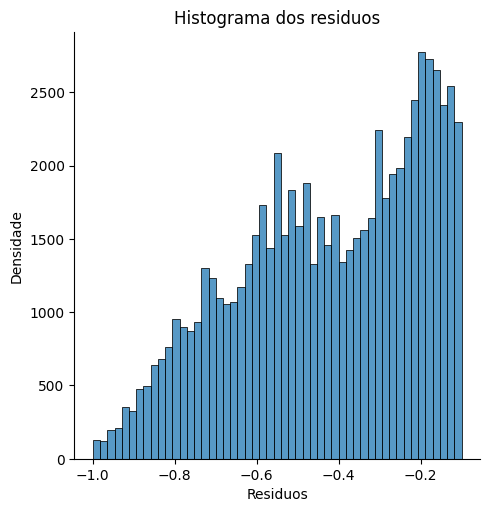

In [786]:
sns.displot(x='residuos', data=residuos_faixa_erro)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

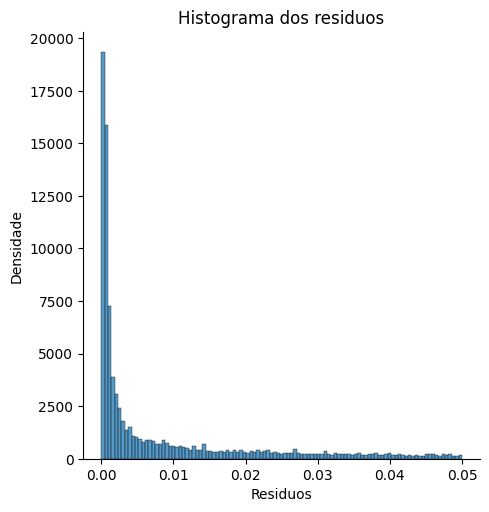

In [196]:
sns.displot(x='residuos', data=residuos_faixa_acerto)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")

plt.show()

In [197]:
desc_erro = residuos_faixa_erro.describe()
desc_acerto = residuos_faixa_acerto.describe()

print("Estatísticas Descritivas para Faixa de Erro:")
desc_erro

Estatísticas Descritivas para Faixa de Erro:


,ano,idade_imovel,area_construida,natureza_imovel,aberto,num_imoveis,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,y_predict,residuos,suposto_pagamento
count,72956.0,72956.000000,72956.000000,72956.000000,72956.000000,72956.000000,72956.000000,7.295600e+04,7.295600e+04,72956.000000,...,72956.000000,72956.000000,72956.000000,72921.000000,72956.000000,72956.000000,72956.000000,72956.000000,72956.000000,7.295600e+04
mean,2023.0,35.051963,137.676081,0.945104,0.998794,75.954150,2692.599509,2.923782e+02,2.984978e+03,0.307267,...,0.726385,0.581492,0.080128,0.789155,3.495614,0.578491,42.521150,0.500274,-0.420380,1.554737e+03
std,0.0,20.171044,597.383054,0.227779,0.034710,262.598554,11167.370424,4.688613e+03,1.256837e+04,0.461364,...,0.329058,0.280047,0.188276,0.407911,6.299815,0.273010,28.819154,0.247065,0.225098,7.757775e+03
min,2023.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.301000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100015,-0.999954,2.370225e+00
25%,2023.0,20.000000,58.000000,1.000000,1.000000,1.000000,590.540000,0.000000e+00,6.725350e+02,0.000000,...,0.428571,0.500000,0.000000,1.000000,0.000000,0.345426,12.000000,0.266884,-0.593995,2.656019e+02
50%,2023.0,35.000000,87.500000,1.000000,1.000000,2.000000,1227.155000,0.000000e+00,1.437305e+03,0.000000,...,1.000000,0.666667,0.000000,1.000000,1.000000,0.593780,40.000000,0.512974,-0.400861,5.977336e+02
75%,2023.0,46.000000,143.000000,1.000000,1.000000,13.000000,2411.640000,0.000000e+00,2.646470e+03,1.000000,...,1.000000,0.800000,0.000000,1.000000,1.000000,0.809810,67.000000,0.698114,-0.213160,1.423134e+03
max,2023.0,106.000000,72704.810000,1.000000,1.000000,1554.000000,981908.440000,1.218366e+06,1.474181e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,19.000000,1.000000,94.000000,1.000000,-0.100004,1.470533e+06


In [198]:
print("\nEstatísticas Descritivas para Faixa de Acerto:")
desc_acerto


Estatísticas Descritivas para Faixa de Acerto:


,ano,idade_imovel,area_construida,natureza_imovel,aberto,num_imoveis,vlr_aberto,vlr_pago,vlr_lancado,pgt_cota_unica,...,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,bairro_encoded,y_predict,residuos,suposto_pagamento
count,91060.0,91060.000000,91060.000000,91060.000000,91060.000000,91060.000000,9.106000e+04,9.106000e+04,9.106000e+04,91060.000000,...,91060.000000,91060.000000,91060.000000,91002.000000,91060.000000,91060.000000,91060.000000,91060.000000,9.106000e+04,9.106000e+04
mean,2023.0,33.111146,156.988869,0.979870,0.122348,10.698199,2.282293e+02,3.097233e+03,3.325463e+03,0.341467,...,0.217230,0.331021,0.892288,0.898365,2.469295,0.877067,42.272688,0.883996,8.291661e-03,3.062603e+03
std,0.0,19.629817,623.875382,0.140444,0.327689,44.229563,4.505409e+03,1.764714e+04,1.818131e+04,0.474204,...,0.354216,0.436687,0.302858,0.302170,5.391108,0.296077,28.502528,0.303716,1.226638e-02,1.742723e+04
min,2023.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.274000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048499,5.960464e-08,-3.206665e+03
25%,2023.0,17.000000,70.630000,1.000000,0.000000,1.000000,0.000000e+00,6.663000e+02,7.987000e+02,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.953335,12.000000,0.978115,5.521902e-04,6.605082e+02
50%,2023.0,32.000000,101.550000,1.000000,0.000000,1.000000,0.000000e+00,1.487495e+03,1.603600e+03,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,0.998006,1.764208e-03,1.472660e+03
75%,2023.0,43.000000,162.875000,1.000000,0.000000,3.000000,0.000000e+00,2.881500e+03,3.057520e+03,1.000000,...,0.285714,0.818182,1.000000,1.000000,1.000000,1.000000,67.000000,0.999433,1.108591e-02,2.855153e+03
max,2023.0,149.000000,57204.000000,1.000000,1.000000,1554.000000,1.274193e+06,1.582603e+06,1.582603e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,19.000000,1.000000,94.000000,1.000000,4.999566e-02,1.535905e+06


In [ ]:
# Histograma para faixa de erro
plt.figure(figsize=(10, 6))
sns.histplot(residuos_faixa_erro['perc_hist_pago'], bins=20, kde=True, color='red', label='Erro', density=True)
plt.title('Distribuição na Faixa de Erro')
plt.legend()
plt.show()

# Histograma para faixa de acerto
plt.figure(figsize=(10, 6))
sns.histplot(residuos_faixa_acerto['perc_hist_pago'], bins=20, kde=True, color='green', label='Acerto', density=True)
plt.title('Distribuição na Faixa de Acerto')
plt.legend()
plt.show()



In [200]:
correlation_erro = residuos_faixa_erro[['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago']].corr()
print("Correlação para Faixa de Erro:")
correlation_erro

Correlação para Faixa de Erro:


,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago
area_construida,1.000000,0.011016,0.051579,0.049039,0.009062,0.005558,-0.005484,0.008223,-0.044421,0.011168
reco_credito,0.011016,1.000000,0.354576,0.377917,0.070747,0.393780,-0.094596,0.014649,-0.398396,0.076144
hist_pagamento,0.051579,0.354576,1.000000,0.848376,0.141924,0.321594,0.166536,-0.076196,-0.480688,0.030634
hist_lancado,0.049039,0.377917,0.848376,1.000000,0.140835,0.322123,0.212014,-0.050116,-0.518403,-0.032477
percentual_reco_divida_ativa,0.009062,0.070747,0.141924,0.140835,1.000000,0.129213,0.818940,0.126707,-0.206503,-0.142479
percentual_pago_cota,0.005558,0.393780,0.321594,0.322123,0.129213,1.000000,0.145932,-0.089184,-0.405909,0.066727
percentual_reco_debito,-0.005484,-0.094596,0.166536,0.212014,0.818940,0.145932,1.000000,0.096103,-0.255986,-0.285376
idade_imovel,0.008223,0.014649,-0.076196,-0.050116,0.126707,-0.089184,0.096103,1.000000,0.127229,-0.123141
tipo_contribuinte,-0.044421,-0.398396,-0.480688,-0.518403,-0.206503,-0.405909,-0.255986,0.127229,1.000000,0.025552
percentual_pago,0.011168,0.076144,0.030634,-0.032477,-0.142479,0.066727,-0.285376,-0.123141,0.025552,1.000000


In [201]:
correlation_acerto = residuos_faixa_acerto[['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago']].corr()
print("\nCorrelação para Faixa de Acerto:")
correlation_acerto


Correlação para Faixa de Acerto:


,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago
area_construida,1.000000,0.031396,0.080443,0.081303,-0.003616,0.026456,-0.011659,0.010625,-0.116071,0.025289
reco_credito,0.031396,1.000000,0.110493,0.113178,-0.278850,0.192404,-0.616004,-0.158097,-0.209528,0.813884
hist_pagamento,0.080443,0.110493,1.000000,0.999697,0.103071,0.160093,0.031111,-0.082036,-0.382463,0.051400
hist_lancado,0.081303,0.113178,0.999697,1.000000,0.105041,0.161190,0.035417,-0.082709,-0.386412,0.051011
percentual_reco_divida_ativa,-0.003616,-0.278850,0.103071,0.105041,1.000000,-0.035539,0.685576,0.103997,-0.088232,-0.310024
percentual_pago_cota,0.026456,0.192404,0.160093,0.161190,-0.035539,1.000000,-0.112831,-0.054818,-0.265375,0.253235
percentual_reco_debito,-0.011659,-0.616004,0.031111,0.035417,0.685576,-0.112831,1.000000,0.182500,-0.079904,-0.728778
idade_imovel,0.010625,-0.158097,-0.082036,-0.082709,0.103997,-0.054818,0.182500,1.000000,0.073780,-0.225885
tipo_contribuinte,-0.116071,-0.209528,-0.382463,-0.386412,-0.088232,-0.265375,-0.079904,0.073780,1.000000,-0.092594
percentual_pago,0.025289,0.813884,0.051400,0.051011,-0.310024,0.253235,-0.728778,-0.225885,-0.092594,1.000000


In [202]:
variaveis = ['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago', 'y_predict', 'residuos']
visualizacao_de_erros = residuos_faixa_erro[variaveis]
visualizacao_de_erros

,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago,y_predict,residuos
0,110.15,3.0,721.31,3339.77,0.600000,0.000000,1.000000,55.0,1.0,0.000000,0.190533,-0.190533
52,89.80,9.0,15377.44,15552.20,0.000000,0.222222,0.111111,37.0,1.0,0.792004,0.892707,-0.100703
59,47.00,9.0,8156.78,9825.52,0.500000,0.111111,0.222222,41.0,1.0,0.000000,0.686422,-0.686422
61,45.00,9.0,8156.78,9825.52,0.500000,0.111111,0.222222,41.0,1.0,0.000000,0.686422,-0.686422
95,93.79,9.0,5455.87,32932.51,0.600000,0.000000,0.555556,10.0,1.0,0.177876,0.476197,-0.298321
...,...,...,...,...,...,...,...,...,...,...,...,...
1924511,123.00,8.0,16630.25,22534.36,0.800000,0.250000,1.000000,41.0,1.0,0.000000,0.591562,-0.591562
1924577,60.00,8.0,43061.57,45403.85,0.777778,0.000000,1.000000,33.0,1.0,0.000000,0.625483,-0.625483
1924591,82.54,7.0,7030.92,9018.56,0.500000,0.000000,0.285714,13.0,1.0,0.000000,0.394860,-0.394860
1924667,118.28,3.0,10430.46,10430.46,0.000000,0.666667,0.333333,0.0,1.0,0.000000,0.812199,-0.812199


In [203]:
variaveis = ['area_construida', 'reco_credito', 'hist_pagamento', 'hist_lancado',
             'percentual_reco_divida_ativa', 'percentual_pago_cota', 'percentual_reco_debito',
            'idade_imovel','tipo_contribuinte', 'percentual_pago', 'y_predict', 'residuos']
visualizacao_de_acertos = residuos_faixa_acerto[variaveis]
visualizacao_de_acertos

,area_construida,reco_credito,hist_pagamento,hist_lancado,percentual_reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,idade_imovel,tipo_contribuinte,percentual_pago,y_predict,residuos
26,32.00,8.0,17014.14,17014.14,0.00,0.250000,0.000000,53.0,1.0,1.0,0.994759,0.005241
38,28.00,8.0,17014.14,17014.14,0.00,0.250000,0.000000,53.0,1.0,1.0,0.994759,0.005241
86,77.88,8.0,7468.29,7468.29,0.00,0.000000,0.000000,38.0,1.0,1.0,0.999604,0.000396
130,73.84,8.0,8218.60,8218.60,0.00,0.000000,0.000000,8.0,1.0,1.0,0.999191,0.000809
159,41.29,2.0,0.00,815.26,0.75,0.000000,1.000000,53.0,1.0,0.0,-0.013404,0.013404
...,...,...,...,...,...,...,...,...,...,...,...,...
1924682,84.00,7.0,3202.69,3789.56,1.00,0.000000,0.142857,26.0,1.0,1.0,0.984100,0.015900
1924691,209.97,8.0,37074.07,37074.07,0.00,0.000000,0.000000,12.0,1.0,1.0,0.999300,0.000700
1924703,86.13,7.0,14683.46,14683.46,0.00,0.142857,0.000000,41.0,1.0,1.0,0.999609,0.000391
1924707,159.80,7.0,14683.46,14683.46,0.00,0.142857,0.000000,31.0,1.0,1.0,0.999834,0.000166


In [805]:
visualizacao_de_acertos['hist_pagamento'].describe()

count    2.029570e+05
mean     2.312097e+05
std      2.114972e+06
min      0.000000e+00
25%      3.276630e+03
50%      1.104071e+04
75%      3.198681e+04
max      8.375863e+07
Name: hist_pagamento, dtype: float64

# ANÁLISE ISOLADA DA RELAÇÃO DE UMA FEATURE COM OS RESÍDUOS

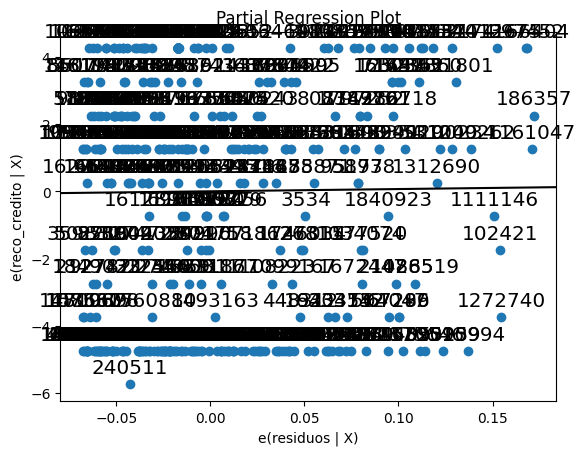

In [695]:
from statsmodels.graphics.regressionplots import plot_partregress
plot_partregress('reco_credito', 'residuos', [], data=residuos_faixa)
plt.show()

# IDENTIFICAÇÃO DE OUTLIERS

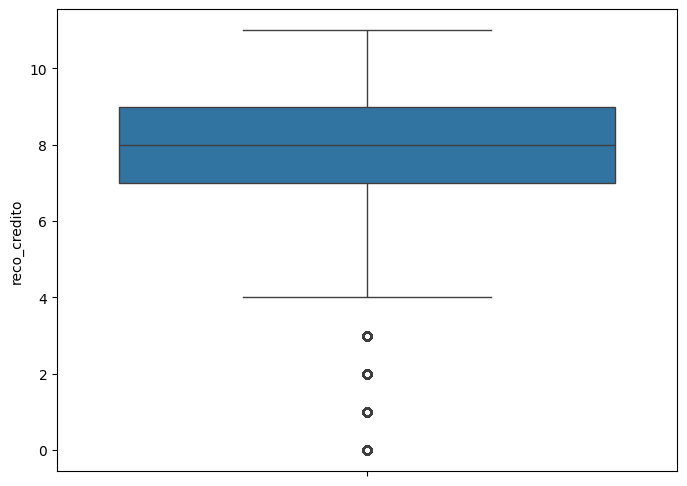

Outliers:


,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,tipo_propriedade,aberto,bairro,num_imoveis,...,pgt_cota_unica,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,reco_divida_ativa,percentual_pago,y_predict,residuos


In [696]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='reco_credito', data=feature_store_credito_23)
plt.show()

# IQR
Q1 = residuos_faixa['reco_credito'].quantile(0.25)
Q3 = residuos_faixa['reco_credito'].quantile(0.75)
IQR = Q3 - Q1

# limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# outliers
outliers = residuos_faixa[(residuos_faixa['reco_credito'] < limite_inferior) | (residuos_faixa['reco_credito'] > limite_superior)]

print("Outliers:")
outliers


In [690]:
outliers[['id_contribuinte', 'dam', 'area_construida', 'reco_debito','reco_credito', 
                          'num_imoveis', 'hist_pagamento', 'hist_lancado','idade_imovel', 'pgt_cota_unica',
                          'vlr_pago', 'vlr_lancado', 'percentual_pago', 'y_predict', 'residuos']]

,id_contribuinte,dam,area_construida,reco_debito,reco_credito,num_imoveis,hist_pagamento,hist_lancado,idade_imovel,pgt_cota_unica,vlr_pago,vlr_lancado,percentual_pago,y_predict,residuos
102421,0dc0da7cfe15e6518e79cf1867e8cc19,256be86be65eb77f90ecf5aaf6be6eb7,204.12,1.0,5.0,3.0,3475.00,24245.52,77.0,0.0,2573.28,2573.28,1.0,0.028110,0.971890
186357,188b9537d43319af8e79cf1867e8cc19,61b7a227f76e6bb090ecf5aaf6be6eb7,78.58,2.0,9.0,2.0,46260.65,53896.74,32.0,0.0,1129.15,1129.15,1.0,0.010290,0.989710
397452,345e467b73c67f33191041d2a59c9dc0,93e2bc0c96950e2690ecf5aaf6be6eb7,0.00,2.0,11.0,53.0,102476.69,395490.26,40.0,1.0,1019.78,1019.78,1.0,0.013988,0.986012
520139,44ed097e02cecdc2d8b209292c0ce31d,c3c6323cab409f5c90ecf5aaf6be6eb7,13.00,0.0,2.0,1.0,145.18,361.97,41.0,1.0,145.18,145.18,1.0,0.058520,0.941480
531040,464cf959656db2b351a3f7d645cf63e5,fa94fb9283debd8390ecf5aaf6be6eb7,92.00,2.0,8.0,1.0,4375.79,13600.25,18.0,0.0,2104.70,2104.70,1.0,0.060017,0.939983
551801,490d79bed89a592d64baa3c49d28f0be,ab5b3e0877802b8490ecf5aaf6be6eb7,0.00,2.0,10.0,13.0,29176.27,61224.36,40.0,1.0,2957.70,2957.70,1.0,0.051840,0.948160
590994,4e4a97244095bcea1603ecd7ff6be21f,a967f9737e73332f90ecf5aaf6be6eb7,31.44,0.0,2.0,1.0,273.84,634.63,57.0,0.0,257.83,257.83,1.0,0.045198,0.954802
1012675,878ed023fa473bede000edc2a2086273,bef332a3025d93f290ecf5aaf6be6eb7,49.82,2.0,11.0,1554.0,2256124.25,8337187.30,35.0,1.0,253.04,253.04,1.0,0.029806,0.970194
1013174,878ed023fa473bede000edc2a2086273,d5e351ef440d4e9390ecf5aaf6be6eb7,59.00,2.0,11.0,1554.0,2256124.25,8337187.30,41.0,1.0,411.39,411.39,1.0,0.053840,0.946160
1100234,92dfefb684fb72d09daa7b7dbb545c1c,18379b08f4e665b190ecf5aaf6be6eb7,32.29,2.0,8.0,2.0,28851.10,36504.01,28.0,0.0,515.36,515.36,1.0,0.053937,0.946063


---

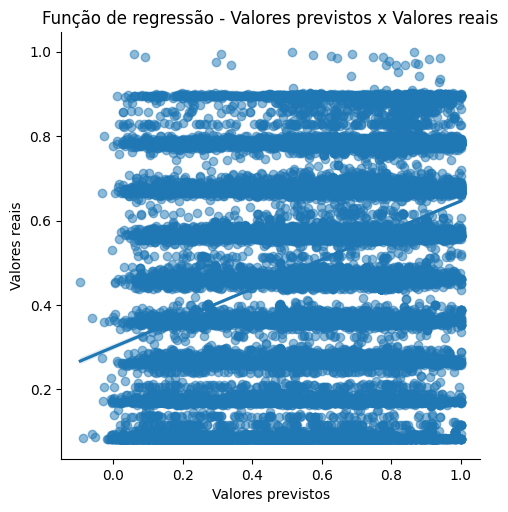

In [204]:
df_regressao = feature_store_credito_23.query("percentual_pago != 1").query("percentual_pago != 0")

sns.lmplot(x='y_predict' , y='percentual_pago', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")
plt.show()

In [ ]:
# Amostras
df_regressao = resid.sample(n=140000)

sns.lmplot(x='y_predict' , y='percentual_pago', data=feature_store_credito_22, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais") 

plt.show()

# REGRESSÃO LOGÍSTICA

In [73]:
feature_store_credito.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago'],
      dtype='object')

In [74]:
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

In [75]:
feature_store_credito_22.shape[0]

340659

### Adicionando variável para regressão logística

In [76]:
feature_store_credito_22['pagamento'] = np.where(feature_store_credito_22['vlr_pago'] == feature_store_credito_22['vlr_lancado'], 1, 0)

C:\Users\Acer\AppData\Local\Temp\ipykernel_24084\1652875452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_store_credito_22['pagamento'] = np.where(feature_store_credito_22['vlr_pago'] == feature_store_credito_22['vlr_lancado'], 1, 0)


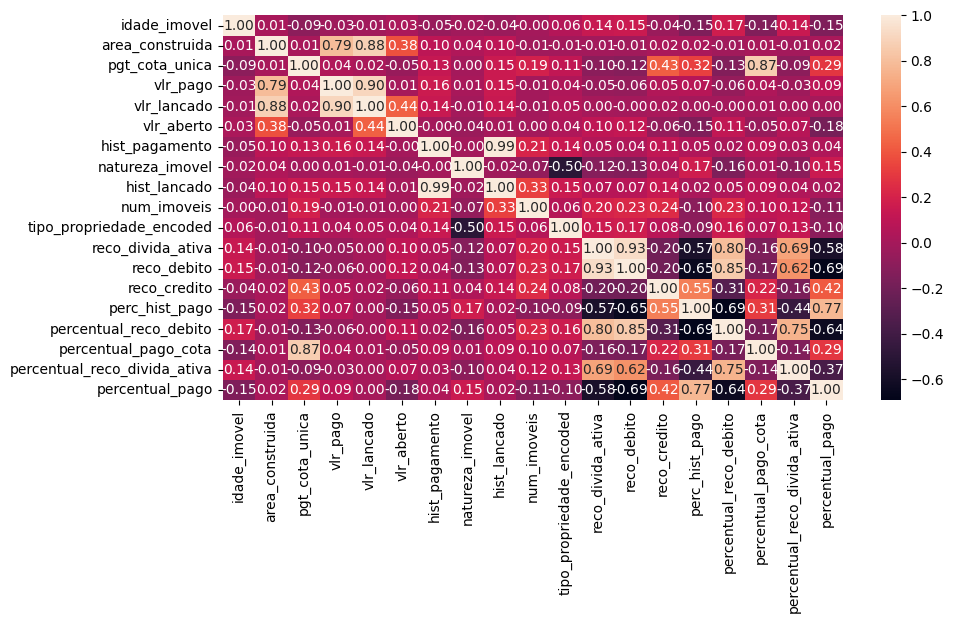

In [77]:
matriz_correlacao = feature_store_credito_22[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 'natureza_imovel',
                                    'hist_lancado', 'num_imoveis', 'tipo_propriedade_encoded',
                                    'reco_divida_ativa','reco_debito','reco_credito',
                                    'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
                                    'percentual_reco_divida_ativa', 'percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [78]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [79]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [81]:
normalizador = RobustScaler() #StandardScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

## REGRESSÃO LOGÍSTICA XGBOOST

In [82]:
xbg_logistico = XGBClassifier(objective="binary:logistic", random_state=42)
xbg_logistico.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [83]:
Predicao_probabilidade = xbg_logistico.predict_proba(X_test)[:, 1]

In [84]:
Predicao_0_ou_1 = xbg_logistico.predict(X_test)

In [85]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,24518,4555
Real Positivo,3290,69835


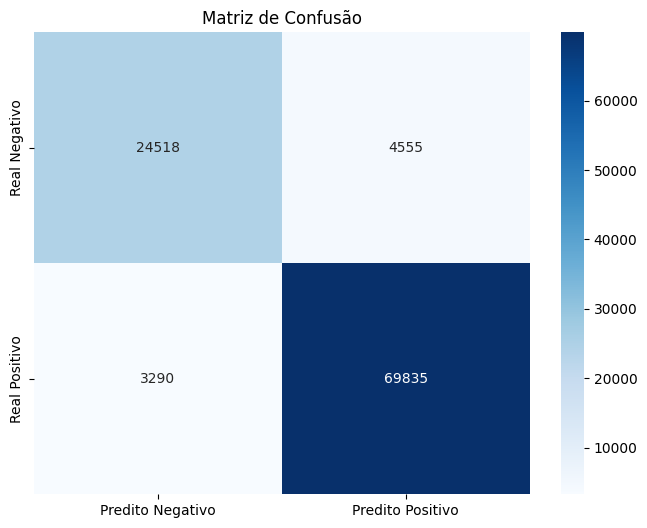

In [86]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [87]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.923237245347267
ROC AUC: 0.9802864772172377
Precisão: 0.9387686517004974
Revocação (Sensibilidade): 0.955008547008547
F1 Score: 0.9468189675626207


---

## REGRESSÃO LOGÍSTICA

In [88]:
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, y_train)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
Predicao_probabilidade = modelo_logistico.predict_proba(X_test)[:, 1]

In [90]:
Predicao_0_ou_1 = modelo_logistico.predict(X_test)

In [91]:
conf_matrix = confusion_matrix(y_test, Predicao_0_ou_1)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,21291,7782
Real Positivo,3596,69529


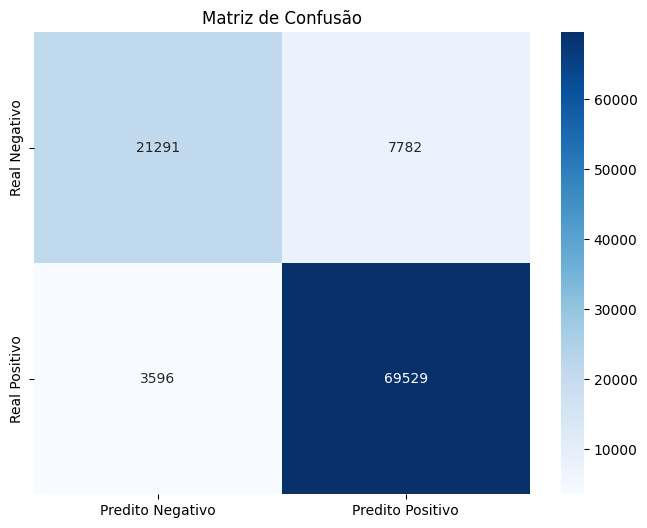

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [93]:
acuracia = accuracy_score(y_test, Predicao_0_ou_1)
roc_auc = roc_auc_score(y_test, Predicao_probabilidade)
precisao = precision_score(y_test, Predicao_0_ou_1)
revocacao = recall_score(y_test, Predicao_0_ou_1)
f1 = f1_score(y_test, Predicao_0_ou_1)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.8886670972034678
ROC AUC: 0.9479279757027771
Precisão: 0.8993416202092845
Revocação (Sensibilidade): 0.9508239316239316
F1 Score: 0.9243665080166982


---

# PREDIÇÃO

In [204]:
feature_store_credito_23.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago'],
      dtype='object')

In [205]:
df_feature_store_predict = feature_store_credito_23.copy()

In [206]:
df_feature_store_predict.isnull().sum()

id_contribuinte                   0
dam                               0
id_imovel                         0
ano                               0
idade_imovel                      0
area_construida                   0
natureza_imovel                   0
tipo_propriedade                  0
bairro                            0
aberto                            0
num_imoveis                       0
vlr_aberto                        0
vlr_pago                          0
vlr_lancado                       0
pgt_cota_unica                    0
hist_cota_unica                   0
hist_pagamento                    0
hist_lancado                      0
reco_debito                       0
reco_credito                      0
reco_divida_ativa                 0
percentual_pago_cota              0
percentual_reco_debito            0
percentual_reco_divida_ativa      0
percentual_pago                   0
tipo_contribuinte               228
tipo_propriedade_encoded          0
perc_hist_pago              

In [207]:
df_feature_store_predict.shape[0]

344781

In [208]:
df_feature_store_predict['pagamento'] = np.where(df_feature_store_predict['vlr_pago'] == df_feature_store_predict['vlr_lancado'], 1, 0)

In [209]:
df_feature_store_predict.head()

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,reco_credito,reco_divida_ativa,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,3.0,0.0,0.00,1.0,0.6,0.0,1.0,1,0.215976,0
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,8.0,0.0,0.00,0.0,0.0,1.0,1.0,0,1.000000,1
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,0,1.000000,1
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,1
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,8.0,0.0,0.25,0.0,0.0,1.0,1.0,17,1.000000,1


In [210]:
variaveis = ['idade_imovel', 'num_imoveis','natureza_imovel','reco_credito', 
             'perc_hist_pago','percentual_reco_debito','percentual_pago_cota',
             'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
             'tipo_propriedade_encoded']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['idade_imovel', 'num_imoveis', 'natureza_imovel', 'reco_credito',
       'perc_hist_pago', 'percentual_reco_debito', 'percentual_pago_cota',
       'reco_divida_ativa', 'percentual_reco_divida_ativa', 'pagamento',
       'tipo_propriedade_encoded'],
      dtype='object')

In [211]:
variaveis_selecionadas.isnull().sum()

idade_imovel                    0
num_imoveis                     0
natureza_imovel                 0
reco_credito                    0
perc_hist_pago                  0
percentual_reco_debito          0
percentual_pago_cota            0
reco_divida_ativa               0
percentual_reco_divida_ativa    0
pagamento                       0
tipo_propriedade_encoded        0
dtype: int64

In [212]:
y = variaveis_selecionadas['pagamento']
x = variaveis_selecionadas.drop(columns=['pagamento'])

In [213]:
predicao_0_1 = xbg_logistico.predict(x)
predicao = xbg_logistico.predict_proba(x)[:, 1]

In [214]:
observado = df_feature_store_predict['pagamento']

# Achando limiar para corte

In [105]:
range_predicoes = pd.DataFrame(predicao).rename(columns={0:'prob'})
range_predicoes

,prob
0,0.005363
1,0.999948
2,0.999976
3,0.999864
4,0.999928
...,...
344776,0.999922
344777,0.999917
344778,0.999928
344779,0.999950


In [106]:
def calcular_f1(y_true, y_prob, ponto_de_corte):
    y_pred = (y_prob >= ponto_de_corte).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return ponto_de_corte, f1, conf_matrix

In [107]:
hist_f1 = []
real_negativo = []
real_positivo = []
predito_negativo = []
predito_positivo = []

for ponto_de_corte in np.linspace(0.0, 0.99, num=50):
    ponto, f1, matriz_confusao = calcular_f1(observado.values, range_predicoes['prob'].values, ponto_de_corte)
    hist_f1.append(f1)
    real_negativo.append(matriz_confusao[0, 1])
    real_positivo.append(matriz_confusao[1, 0])
    predito_negativo.append(matriz_confusao[0, 0])
    predito_positivo.append(matriz_confusao[1, 1])

df_resultado = pd.DataFrame({
    'Limiar_corte': np.linspace(0.0, 0.99, num=50),
    'F1_Score': hist_f1,
    'real_negativo': real_negativo,
    'real_positivo': real_positivo,
    'predito_negativo': predito_negativo,
    'predito_positivo': predito_positivo
})
df_resultado = df_resultado.query('F1_Score > 0.90')
df_resultado = df_resultado.sort_values(by='real_positivo', ascending=False)
df_resultado

,Limiar_corte,F1_Score,real_negativo,real_positivo,predito_negativo,predito_positivo
42,0.848571,0.900564,6868,35426,110965,191522
41,0.828367,0.904595,7994,32931,109839,194017
40,0.808163,0.907530,9167,30804,108666,196144
39,0.787959,0.910089,10257,28879,107576,198069
38,0.767755,0.912525,11482,26876,106351,200072
37,0.747551,0.914172,12686,25197,105147,201751
36,0.727347,0.915324,13818,23773,104015,203175
35,0.707143,0.916339,14975,22379,102858,204569
34,0.686939,0.917153,16240,20972,101593,205976
33,0.666735,0.918161,17421,19551,100412,207397


In [215]:
limiar = 0.666735
predicoes_binarias = (predicao >= limiar).astype(int)

In [216]:
df_resultado_predict = df_feature_store_predict.copy()

In [217]:
df_resultado_predict['predicao'] = predicao
df_resultado_predict['predicao_binaria'] = predicoes_binarias

In [218]:
df_resultado_predict

,id_contribuinte,dam,id_imovel,ano,idade_imovel,area_construida,natureza_imovel,tipo_propriedade,bairro,aberto,...,percentual_pago_cota,percentual_reco_debito,percentual_reco_divida_ativa,percentual_pago,tipo_contribuinte,tipo_propriedade_encoded,perc_hist_pago,pagamento,predicao,predicao_binaria
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,55.0,110.15,1,CASA,AREIAS,1,...,0.000000,1.0,0.6,0.0,1.0,1,0.215976,0,0.005363,0
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,30.0,132.71,1,APARTAMENTO,AFLITOS,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999948,1
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,15.0,151.45,1,APARTAMENTO,BOA VIAGEM,0,...,0.250000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999976,1
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,53.0,32.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,1,0.999864,1
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,30.0,53.00,1,SALA,BOA VISTA,0,...,0.250000,0.0,0.0,1.0,1.0,17,1.000000,1,0.999928,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,12.0,209.97,1,APARTAMENTO,BOA VIAGEM,0,...,0.000000,0.0,0.0,1.0,1.0,0,1.000000,1,0.999922,1
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,40.0,213.00,1,CASA,CORDEIRO,0,...,0.000000,0.0,0.0,1.0,1.0,1,1.000000,1,0.999917,1
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,41.0,86.13,1,APARTAMENTO,IPUTINGA,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,1,0.999928,1
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,31.0,159.80,1,APARTAMENTO,CORDEIRO,0,...,0.142857,0.0,0.0,1.0,1.0,0,1.000000,1,0.999950,1


In [219]:
df_resultado_predict[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao']]

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao
0,0000398c485f8b42344d77602867ec09,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,2023.0,1,1158.44,0.00,0.215976,0,0.0,0.005363
8,00003a695da4777aec557718ffae83ea,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,2023.0,0,0.00,1904.40,1.000000,1,1.0,0.999948
12,000046c85d18a6f7968646cfc1e328f2,4a3c62195a4def8990ecf5aaf6be6eb7,4c440987414316f6,2023.0,0,0.00,3982.40,1.000000,1,1.0,0.999976
26,0000b23be5378f1b8e79cf1867e8cc19,68de448b7a43947490ecf5aaf6be6eb7,e8f779a348c050b1,2023.0,0,0.00,351.48,1.000000,1,1.0,0.999864
29,0000b23be5378f1b8e79cf1867e8cc19,99fe1c4df3bee62f90ecf5aaf6be6eb7,f42760d51259d181,2023.0,0,0.00,1066.80,1.000000,1,1.0,0.999928
...,...,...,...,...,...,...,...,...,...,...,...
1924691,ffff3836dbf935321bc34267b5521a39,e896b1265fdb1d5390ecf5aaf6be6eb7,0cfe1aa6943523cf,2023.0,0,0.00,5681.83,1.000000,1,1.0,0.999922
1924698,ffff63826b501d84d8b209292c0ce31d,f307f8927e07ff0690ecf5aaf6be6eb7,e5ef9115acfa782e,2023.0,0,0.00,2085.70,1.000000,1,1.0,0.999917
1924703,ffffc6563e67d8b38e79cf1867e8cc19,a25c32e4e030935c90ecf5aaf6be6eb7,18be5a8c332a3892,2023.0,0,0.00,746.40,1.000000,1,1.0,0.999928
1924707,ffffc6563e67d8b38e79cf1867e8cc19,d73b874b4949665490ecf5aaf6be6eb7,0fb91ca37fa4509b,2023.0,0,0.00,1786.30,1.000000,1,1.0,0.999950


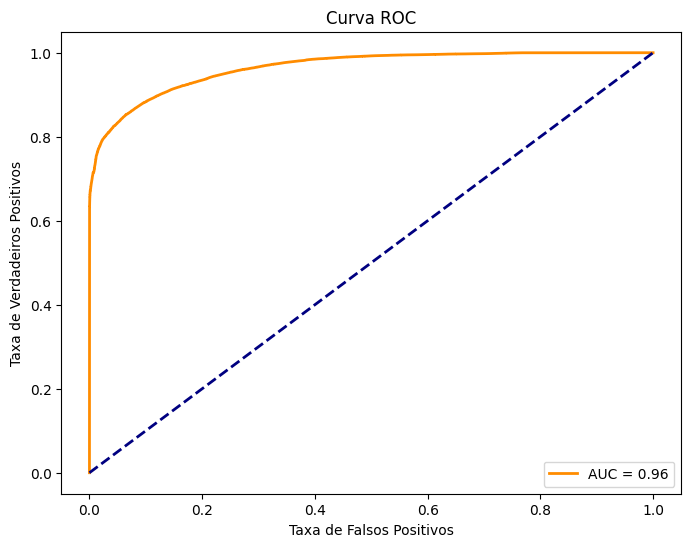

In [152]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(observado, predicao)

# Encontrar o índice do limiar mais próximo ao valor desejado
indice_limiar = (np.abs(thresholds - limiar)).argmin()
limiar_selecionado = thresholds[indice_limiar]
predicoes_binarias = (predicao >= limiar_selecionado).astype(int)

fpr, tpr, _ = roc_curve(observado, predicao)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

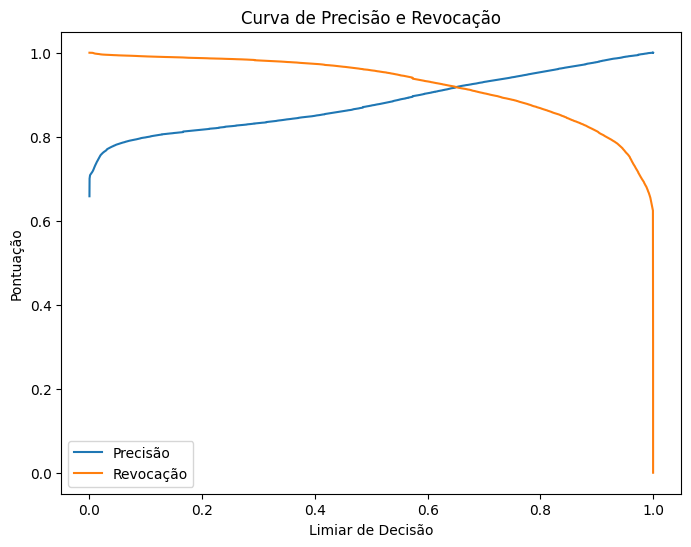

In [311]:
from sklearn.metrics import precision_recall_curve

precision, recall, limiar = precision_recall_curve(observado, predicao)

plt.figure(figsize=(8, 6))
plt.plot(limiar, precision[:-1], label='Precisão')
plt.plot(limiar, recall[:-1], label='Revocação')
plt.xlabel('Limiar de Decisão')
plt.ylabel('Pontuação')
plt.title('Curva de Precisão e Revocação')
plt.legend(loc='lower left')
plt.show()


### MATRIZ DE CONFUSÃO

In [220]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)

df_conf_matrix = pd.DataFrame(conf_matrix, index=['Real Negativo', 'Real Positivo'], columns=['Predito Negativo', 'Predito Positivo'])
print("Matriz de Confusão:")
df_conf_matrix 

Matriz de Confusão:


,Predito Negativo,Predito Positivo
Real Negativo,100412,17421
Real Positivo,19551,207397


### DISTRIBUIÇÃO PERCENTUAL DA MATRIZ DE CONFUSÃO

In [221]:
conf_matrix = confusion_matrix(observado, predicoes_binarias)
total_observacoes = len(observado)
conf_matrix_percentual = conf_matrix / total_observacoes * 100

rotulos_verdadeiros = ['Real Negativo', 'Real Positivo']
rotulos_previstos = ['Predito Negativo', 'Predito Positivo']

df_conf_matrix_percentual = pd.DataFrame(conf_matrix_percentual, index=rotulos_verdadeiros, columns=rotulos_previstos)
print("Matriz de Confusão em Percentual:")
df_conf_matrix_percentual

Matriz de Confusão em Percentual:


,Predito Negativo,Predito Positivo
Real Negativo,29.123415,5.052773
Real Positivo,5.670556,60.153257


### Corte em que o nosso f1-score é o melhor = 0.918161

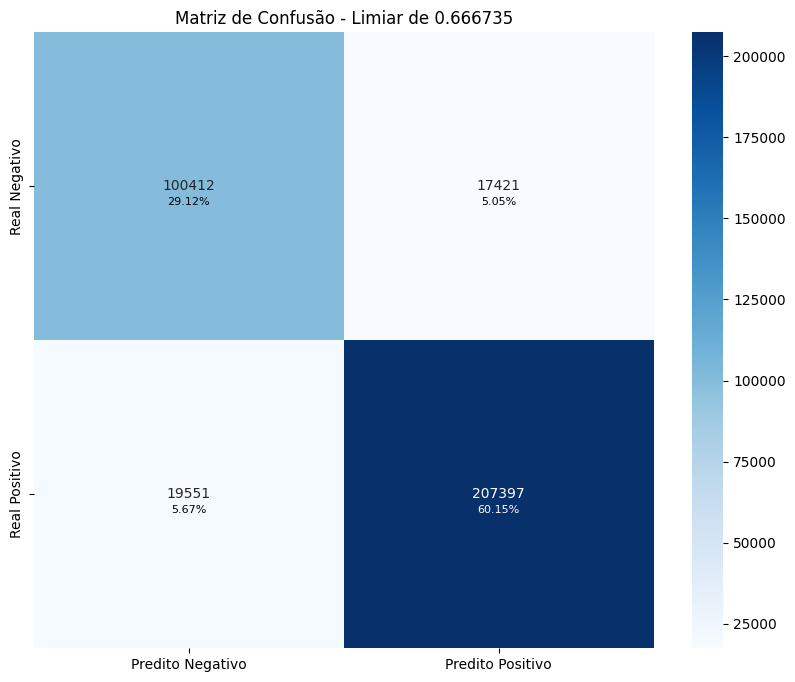

In [222]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

### Corte em que aumentamos os erros onde a pessoa paga e prevemos que ela não pagaria

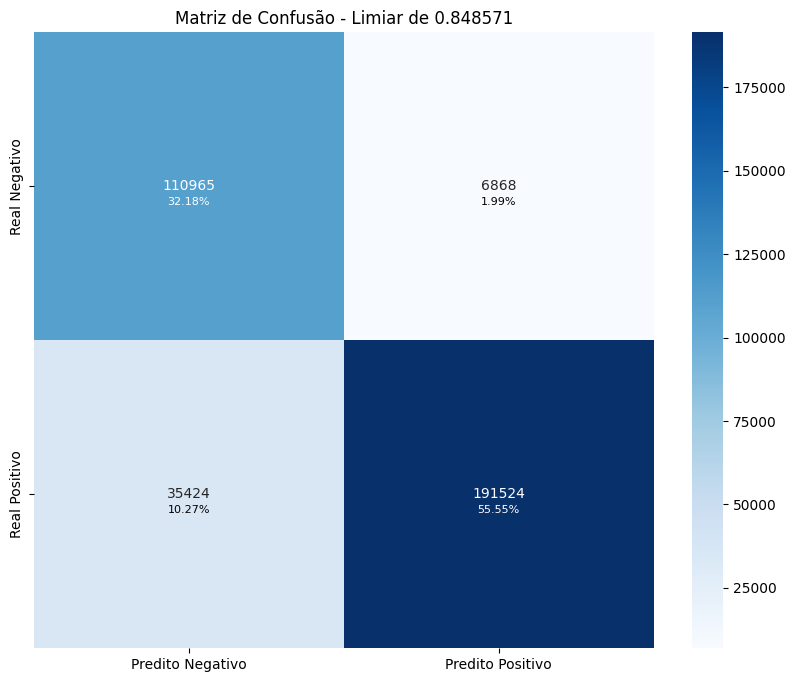

In [155]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - Limiar de {limiar}")

for i in range(df_conf_matrix.shape[0]):
    for j in range(df_conf_matrix.shape[1]):
        text = f'{df_conf_matrix_percentual.iloc[i, j]:.2f}%'
        color = 'black' if df_conf_matrix.iloc[i, j] < df_conf_matrix.values.max() / 2 else 'white'
        plt.text(j + 0.5, i + 0.5 + 0.05, text, ha='center', va='center', color=color, fontsize=8)
plt.show()

In [225]:
acuracia = accuracy_score(observado, predicoes_binarias)
roc_auc = roc_auc_score(observado, predicao)
precisao = precision_score(observado, predicoes_binarias)
revocacao = recall_score(observado, predicoes_binarias)
f1 = f1_score(observado, predicoes_binarias)
print(f"Accuracia: {acuracia}")
print(f"ROC AUC: {roc_auc}")
print(f"Precisão: {precisao}")
print(f"Revocação (Sensibilidade): {revocacao}")
print(f"F1 Score: {f1}")

Accuracia: 0.892766712782897
ROC AUC: 0.9640764453631063
Precisão: 0.9225106530615876
Revocação (Sensibilidade): 0.9138525124698169
F1 Score: 0.9181611719341429


# RESÍDUOS

In [194]:
df_resultado_predict.columns

Index(['id_contribuinte', 'dam', 'id_imovel', 'ano', 'idade_imovel',
       'area_construida', 'natureza_imovel', 'tipo_propriedade', 'bairro',
       'aberto', 'num_imoveis', 'vlr_aberto', 'vlr_pago', 'vlr_lancado',
       'pgt_cota_unica', 'hist_cota_unica', 'hist_pagamento', 'hist_lancado',
       'reco_debito', 'reco_credito', 'reco_divida_ativa',
       'percentual_pago_cota', 'percentual_reco_debito',
       'percentual_reco_divida_ativa', 'percentual_pago', 'tipo_contribuinte',
       'tipo_propriedade_encoded', 'perc_hist_pago', 'pagamento', 'predicao',
       'predicao_binaria'],
      dtype='object')

In [224]:
resultado = df_resultado_predict[['id_contribuinte', 'dam', 'id_imovel', 'ano',
                      'aberto','vlr_aberto', 'vlr_pago', 'vlr_lancado',
                      'perc_hist_pago', 'pagamento','percentual_pago', 'predicao', 'predicao_binaria']].copy()
aberto = resultado.query('vlr_pago != vlr_lancado')
fechado = resultado.query('vlr_pago == vlr_lancado')

In [197]:
aberto.select_dtypes(include='object').describe()

,id_contribuinte,dam,id_imovel
count,117833,117833,117833
unique,82579,117833,117779
top,878ed023fa473bede000edc2a2086273,13fbc8d9654c9e3190ecf5aaf6be6eb7,16e0ff847b850e57
freq,1189,1,2


## LIMIAR 66

### Este limiar (corte) é o melhor limiar onde eu equilibro meu modelo com a métrica f1-score nas duas diagonais

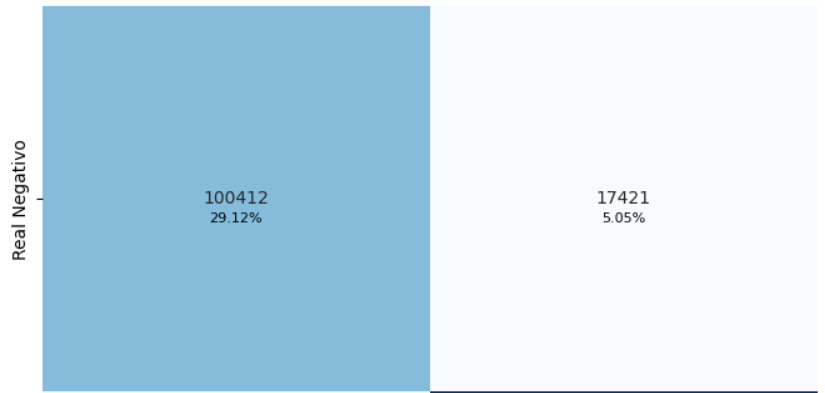

### Casos em que a pessoa deve e eu estou predizendo que ela vai pagar

In [226]:
limiar_66_aberto = pd.DataFrame()
limiar_66_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_66_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 1,'dam'].nunique()]
limiar_66_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_66_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'vlr_aberto'].sum()]
limiar_66_aberto['percentual_a_arrecadar'] = (limiar_66_aberto['valor_predito_a_receber'] / limiar_66_aberto['valor_em_aberto']) * 100

limiar_66_aberto['valor_em_aberto'] = limiar_66_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_66_aberto['valor_predito_a_receber'] = limiar_66_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual_a_arrecadar
0,17408,17421,"R$ 291.039.441,82","R$ 49.068.735,52",16.859823


### Casos em que a pessoa deve e eu estou predizendo que ela não vai pagar

In [228]:
limiar_66_aberto = pd.DataFrame()
limiar_66_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_66_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 0,'dam'].nunique()]
limiar_66_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_66_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'vlr_aberto'].sum()]
limiar_66_aberto['percentual'] = (limiar_66_aberto['valor_predito_a_receber'] / limiar_66_aberto['valor_em_aberto']) * 100

limiar_66_aberto['valor_em_aberto'] = limiar_66_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_66_aberto['valor_predito_a_receber'] = limiar_66_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual
0,100371,100412,"R$ 291.039.441,82","R$ 241.970.706,30",83.140177


### Este limiar (corte) faz com que venhamos predizer em casos onde a pessoa pagou eu dizer moderadamente que ela não vai pagar

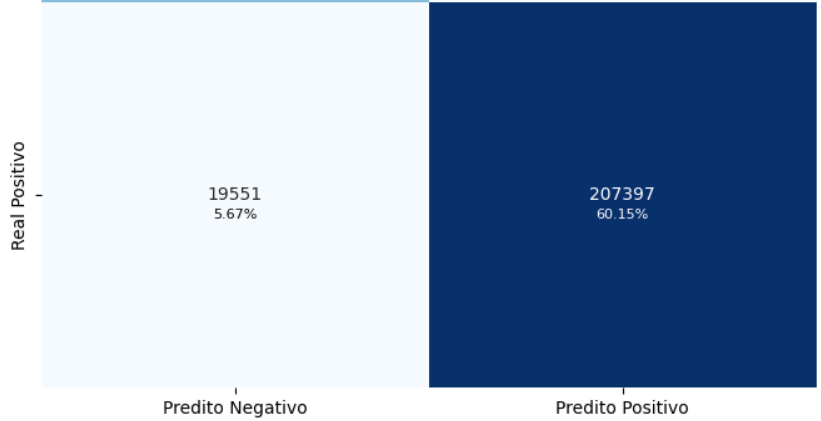

### Casos em que a pessoa pagou e eu estou predizendo que ela não vai pagar

In [231]:
limiar_66_fechado = pd.DataFrame()
limiar_66_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_66_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'dam'].nunique()]
limiar_66_fechado['valor_total_pago'] = [fechado['vlr_pago'].sum()]
limiar_66_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'vlr_pago'].sum()]
limiar_66_fechado['percentual_a_arrecadar'] = (limiar_66_fechado['valor_predito_a_receber'] / limiar_66_fechado['valor_total_pago']) * 100

limiar_66_fechado['valor_total_pago'] = limiar_66_fechado['valor_total_pago'].apply(formatar_moeda)
limiar_66_fechado['valor_predito_a_receber'] = limiar_66_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_fechado

,imoveis,dams,valor_total_pago,valor_predito_a_receber,percentual_a_arrecadar
0,19548,19551,"R$ 773.295.993,13","R$ 50.851.593,84",6.575955


### Casos em que a pessoa pagou e eu estou predizendo que ela vai pagar

In [232]:
limiar_66_fechado = pd.DataFrame()
limiar_66_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_66_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'dam'].nunique()]
limiar_66_fechado['valor_total_pago'] = [fechado['vlr_pago'].sum()]
limiar_66_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'vlr_pago'].sum()]
limiar_66_fechado['percentual_a_arrecadar'] = (limiar_66_fechado['valor_predito_a_receber'] / limiar_66_fechado['valor_total_pago']) * 100

limiar_66_fechado['valor_total_pago'] = limiar_66_fechado['valor_total_pago'].apply(formatar_moeda)
limiar_66_fechado['valor_predito_a_receber'] = limiar_66_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_66_fechado

,imoveis,dams,valor_total_pago,valor_predito_a_receber,percentual_a_arrecadar
0,207378,207397,"R$ 773.295.993,13","R$ 722.444.399,29",93.424045


# LIMIAR 84

### Este limiar (corte) faz com que venhamos predizer em casos onde a dívida esta em aberto assumir que menos pessoas irão pagar

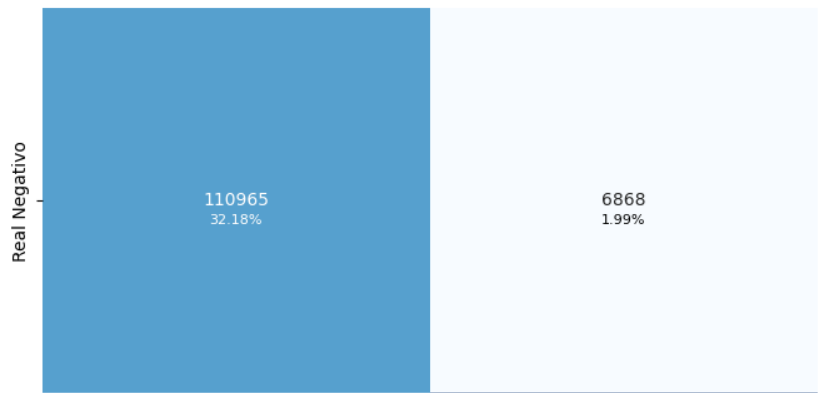

### Casos em que a pessoa deve e eu estou predizendo que ela vai pagar

In [199]:
limiar_84_aberto = pd.DataFrame()
limiar_84_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_84_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 1,'dam'].nunique()]
limiar_84_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_84_aberto['valor_predito_a_receber'] = [aberto.loc[aberto['predicao_binaria'] == 1, 'vlr_aberto'].sum()]
limiar_84_aberto['percentual_a_arrecadar'] = (limiar_84_aberto['valor_predito_a_receber'] / limiar_84_aberto['valor_em_aberto']) * 100

limiar_84_aberto['valor_em_aberto'] = limiar_84_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_84_aberto['valor_predito_a_receber'] = limiar_84_aberto['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_receber,percentual_a_arrecadar
0,6859,6868,"R$ 291.039.441,82","R$ 16.749.474,17",5.755053


### Casos em que a pessoa deve e eu estou predizendo que ela não vai pagar

In [200]:
limiar_84_aberto = pd.DataFrame()
limiar_84_aberto['imoveis'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_84_aberto['dams'] = [aberto.loc[aberto['predicao_binaria'] == 0,'dam'].nunique()]
limiar_84_aberto['valor_em_aberto'] = [aberto['vlr_aberto'].sum()]
limiar_84_aberto['valor_predito_a_NAO_receber'] = [aberto.loc[aberto['predicao_binaria'] == 0, 'vlr_aberto'].sum()]
limiar_84_aberto['percentual'] = (limiar_84_aberto['valor_predito_a_NAO_receber'] / limiar_84_aberto['valor_em_aberto']) * 100

limiar_84_aberto['valor_em_aberto'] = limiar_84_aberto['valor_em_aberto'].apply(formatar_moeda)
limiar_84_aberto['valor_predito_a_NAO_receber'] = limiar_84_aberto['valor_predito_a_NAO_receber'].apply(formatar_moeda)
limiar_84_aberto

,imoveis,dams,valor_em_aberto,valor_predito_a_NAO_receber,percentual
0,110920,110965,"R$ 291.039.441,82","R$ 274.289.967,65",94.244947


### Este limiar (corte) faz com que venhamos predizer em casos onde a pessoa pagou eu dizer que ela não vai pagar

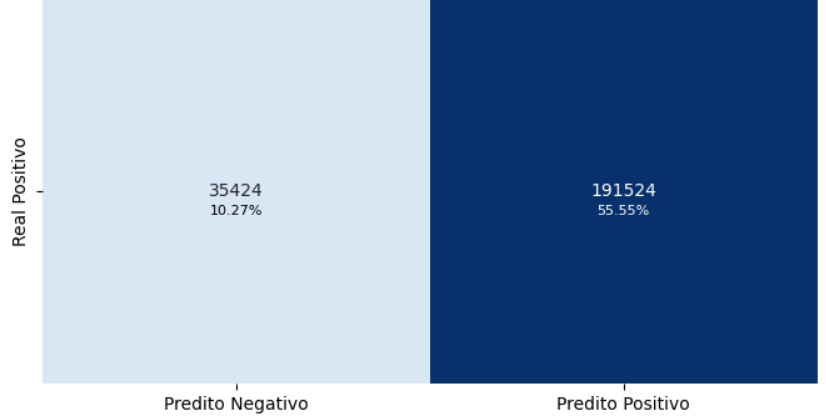

### Casos em que a pessoa pagou e eu estou predizendo que ela não vai pagar

In [201]:
limiar_84_fechado = pd.DataFrame()
limiar_84_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'id_imovel'].nunique()]
limiar_84_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 0,'dam'].nunique()]
limiar_84_fechado['valor_quitado'] = [fechado['vlr_pago'].sum()]
limiar_84_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 0, 'vlr_pago'].sum()]
limiar_84_fechado['percentual_a_arrecadar'] = (limiar_84_fechado['valor_predito_a_receber'] / limiar_84_fechado['valor_quitado']) * 100

limiar_84_fechado['valor_quitado'] = limiar_84_fechado['valor_quitado'].apply(formatar_moeda)
limiar_84_fechado['valor_predito_a_receber'] = limiar_84_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_fechado

,imoveis,dams,valor_quitado,valor_predito_a_receber,percentual_a_arrecadar
0,35421,35424,"R$ 773.295.993,13","R$ 104.988.903,54",13.576807


### Casos em que a pessoa pagou e eu estou predizendo que ela vai pagar

In [203]:
limiar_84_fechado = pd.DataFrame()
limiar_84_fechado['imoveis'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'id_imovel'].nunique()]
limiar_84_fechado['dams'] = [fechado.loc[fechado['predicao_binaria'] == 1,'dam'].nunique()]
limiar_84_fechado['valor_quitado'] = [fechado['vlr_pago'].sum()]
limiar_84_fechado['valor_predito_a_receber'] = [fechado.loc[fechado['predicao_binaria'] == 1, 'vlr_pago'].sum()]
limiar_84_fechado['percentual_a_arrecadar'] = (limiar_84_fechado['valor_predito_a_receber'] / limiar_84_fechado['valor_quitado']) * 100

limiar_84_fechado['valor_quitado'] = limiar_84_fechado['valor_quitado'].apply(formatar_moeda)
limiar_84_fechado['valor_predito_a_receber'] = limiar_84_fechado['valor_predito_a_receber'].apply(formatar_moeda)
limiar_84_fechado

,imoveis,dams,valor_quitado,valor_predito_a_receber,percentual_a_arrecadar
0,191505,191524,"R$ 773.295.993,13","R$ 668.307.089,59",86.423193


---

In [486]:
formatar_moeda(aberto['vlr_pago'].sum())

'R$ 722.444.399,29'

In [434]:
formatar_moeda(fechado['suposto_valor'].sum())

'R$ 81.532.674,20'

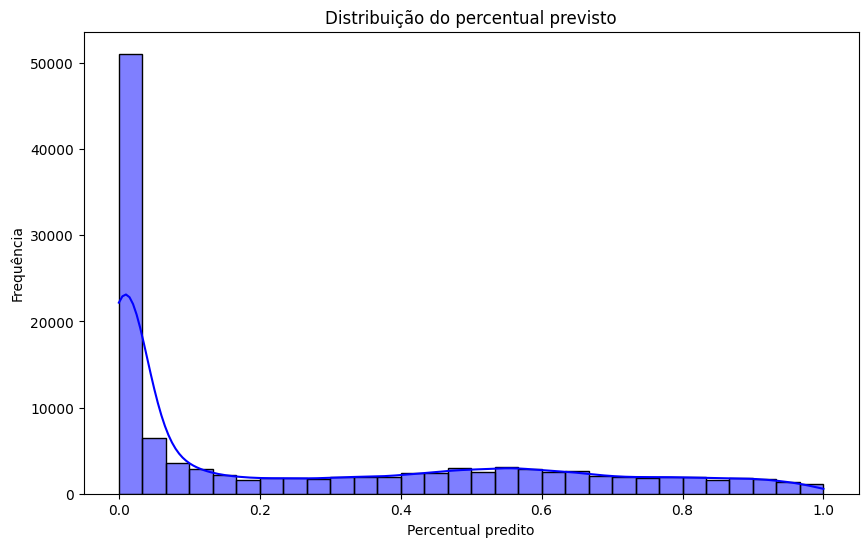

In [435]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['predicao'], kde=True, color='blue', bins=30)
plt.title('Distribuição do percentual previsto')
plt.xlabel('Percentual predito')
plt.ylabel('Frequência')
plt.show()

## Avaliação dos resíduos diferentes de 0 e 1 

In [125]:
fechado['residuos'] =  fechado['percentual_pago'] - fechado['predicao']
resid = fechado[['predicao', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['predicao'] != 0]
resid_not0_not1 = resid_not0[resid_not0['predicao'] != 1]
resid_not0_not1 

,predicao,percentual_pago,residuos
371986,0.000150,1.0,0.999850
1090594,0.000488,1.0,0.999512
1160659,0.000594,1.0,0.999406
325407,0.001184,1.0,0.998816
1517289,0.001395,1.0,0.998605
...,...,...,...
301409,0.999998,1.0,0.000002
301389,0.999998,1.0,0.000002
301374,0.999998,1.0,0.000002
301029,0.999998,1.0,0.000002


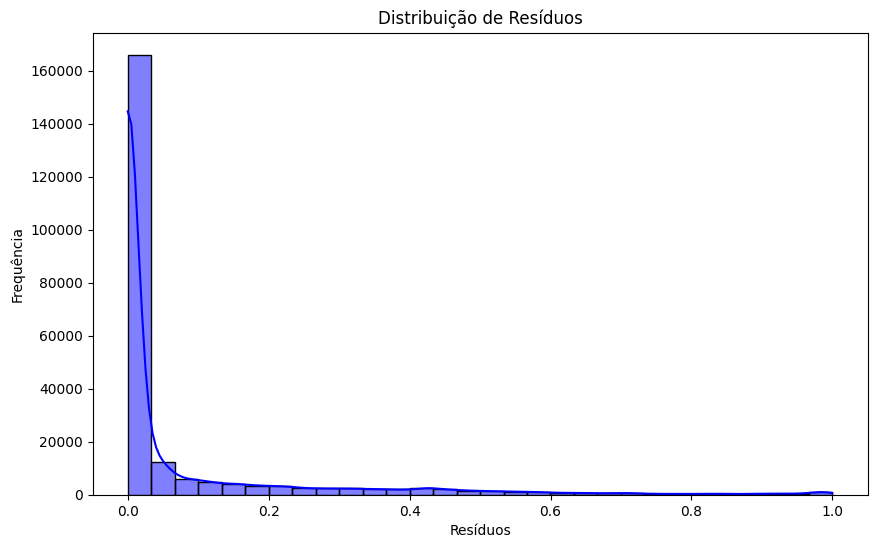

In [130]:
plt.figure(figsize=(10, 6))
sns.histplot(fechado['residuos'], kde=True, color='blue', bins=30)
plt.title('Distribuição de Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

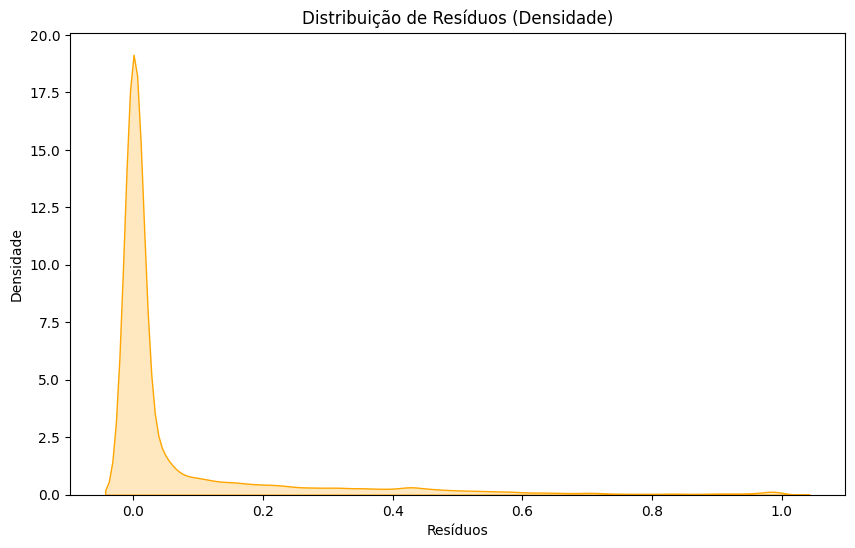

In [131]:
# Ou crie um gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(fechado['residuos'], fill=True, color='orange')
plt.title('Distribuição de Resíduos (Densidade)')
plt.xlabel('Resíduos')
plt.ylabel('Densidade')
plt.show()


In [126]:
def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [127]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",0,0.00000
"[-0.75, -0.5)",0,0.00000
"[-0.5, -0.25)",0,0.00000
"[-0.25, -0.2)",0,0.00000
"[-0.2, -0.15)",0,0.00000
"[-0.15, -0.1)",0,0.00000
"[-0.1, -0.05)",0,0.00000
"[-0.05, 0.0)",0,0.00000
"[0.0, 0.05)",173712,0.76543


In [128]:
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], bins=igr_bins, labels=igr_labels, right=False)

df_summary_residuos = resid.groupby('resid_faixas').agg(
    {'residuos': 'mean', 'percentual_pago': 'mean', 'resid_faixas': 'count'}
).rename(columns={'resid_faixas': 'frequencia'})

df_summary_residuos['perc'] = df_summary_residuos['frequencia'] / df_summary_residuos['frequencia'].sum() * 100
df_summary_residuos

,residuos,percentual_pago,frequencia,perc
resid_faixas,,,,
"[-1.0, -0.75)",NaN,NaN,0,0.000000
"[-0.75, -0.5)",NaN,NaN,0,0.000000
"[-0.5, -0.25)",NaN,NaN,0,0.000000
"[-0.25, -0.2)",NaN,NaN,0,0.000000
"[-0.2, -0.15)",NaN,NaN,0,0.000000
"[-0.15, -0.1)",NaN,NaN,0,0.000000
"[-0.1, -0.05)",NaN,NaN,0,0.000000
"[-0.05, 0.0)",NaN,NaN,0,0.000000
"[0.0, 0.05)",0.003727,1.0,173712,76.542644


In [123]:
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",0,0.00000
1,"[-0.75, -0.5)",0,0.00000
2,"[-0.5, -0.25)",0,0.00000
3,"[-0.25, -0.2)",0,0.00000
4,"[-0.2, -0.15)",0,0.00000
5,"[-0.15, -0.1)",0,0.00000
6,"[-0.1, -0.05)",0,0.00000
7,"[-0.05, 0.0)",0,0.00000
8,"[0.0, 0.05)",173712,0.76543
9,"[0.05, 0.1)",10863,0.04787


In [129]:
residuos_faixa_erro = fechado.query('(residuos >= 0.75) & (residuos <= 1.0)')
# residuos_faixa_acerto = df_resultado_predict.query('(residuos >= 0.00) & (residuos <= 0.05)')
residuos_faixa_erro

,id_contribuinte,dam,id_imovel,ano,aberto,vlr_aberto,vlr_pago,perc_hist_pago,pagamento,percentual_pago,predicao,residuos
192,000777f57c8049368dd06342399984d9,7c39c6ca0cd480bc90ecf5aaf6be6eb7,bc3471350be601d8,2023.0,0,0.0,657.20,0.997733,1,1.0,0.007437,0.992563
255,000a8913b4e31d3d8e79cf1867e8cc19,f365a540a09f16e490ecf5aaf6be6eb7,71711296a8eaa8bb,2023.0,0,0.0,264.32,0.595292,1,1.0,0.094502,0.905498
1752,002997e93d88f909dd9a3cb674b9fb28,f32c4045a12788cb90ecf5aaf6be6eb7,24a29af8f3da6850,2023.0,0,0.0,4019.30,0.978841,1,1.0,0.016583,0.983417
2281,003d77b4d5acedcfcd124eb8021f7dca,144762e90b2ecd9790ecf5aaf6be6eb7,e9e5813660513601,2023.0,0,0.0,1430.10,0.609960,1,1.0,0.171076,0.828924
3623,007719db01137158ec24828071529570,cd58ecb5f4e1305690ecf5aaf6be6eb7,22a2b66ba2b6cdeb,2023.0,0,0.0,1471.30,0.975492,1,1.0,0.202907,0.797093
...,...,...,...,...,...,...,...,...,...,...,...,...
1920051,ff5a338d6b0d75cd9daa7b7dbb545c1c,249c68ff79a85d1590ecf5aaf6be6eb7,94054c7ea04851c0,2023.0,0,0.0,4485.79,0.979829,1,1.0,0.015675,0.984325
1920449,ff6804b40ae92ca8d8b209292c0ce31d,060b63d5a2d819f290ecf5aaf6be6eb7,bedd84876b363f35,2023.0,0,0.0,913.50,0.818445,1,1.0,0.183547,0.816453
1920586,ff6d015ffecc66f08e79cf1867e8cc19,045610abe0f9056090ecf5aaf6be6eb7,63996a8c5cfa2c8a,2023.0,0,0.0,330.39,0.455860,1,1.0,0.205902,0.794098
1920911,ff73d569207c0bec1172306dd24a62d3,8630975b13c7462090ecf5aaf6be6eb7,6e7cc7b0a23776f3,2023.0,0,0.0,1870.49,0.497761,1,1.0,0.124932,0.875068


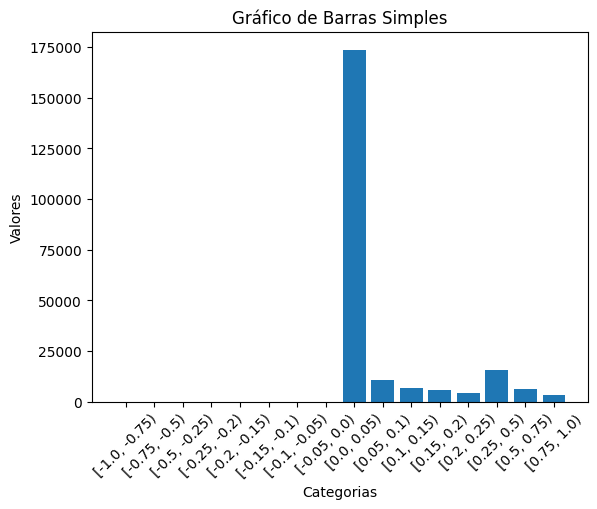

In [124]:
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']
plt.bar(categorias, valores)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')
plt.xticks(rotation=45)
plt.show()

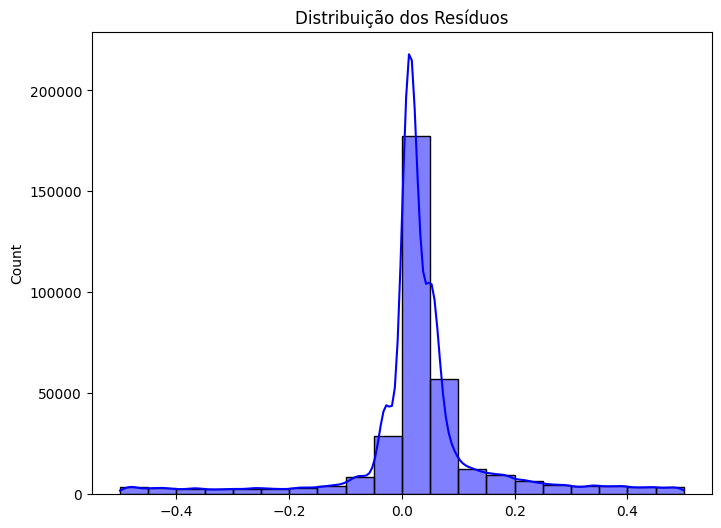

In [233]:
residuos = y_pred_test_23 - y_pred_proba_teste_23
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=20, kde=True, color='blue')
plt.title('Distribuição dos Resíduos')
plt.show()